# KC_Route_Generation
In this notebook, I'll be running through the process of generating a LOT of routes from existing data.

In [22]:
import os
import sys
sys.path.append('../src/reRoute_Dynamics_Core/')
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import shapely.plotting as shapeplt
import pyogrio as pio
import KC_Query_Tools as kqt
import Geography_Tools as gt
import Object_Params as op
import Trip_Simulator as ts
import Instance_Tools as it
import ESS
import multiprocessing

import importlib
importlib.reload(gt)
importlib.reload(op)
importlib.reload(ts)
importlib.reload(it)
importlib.reload(ESS)
importlib.reload(kqt)


# Map path
map_path = '/media/sebastian/Slepnir/KC_Map/map/Incorporated_Areas_of_King_County___citydst_area.shp'

# Use the ridership data to get expected unique riders for a given route, period, and direction!
ridership_data_path = './KC_Example_Data/KC_Route_Data/Ridership/Ridership.csv'

# route data and save directories
route_data_dir = "./KC_Example_Data/KC_Route_Data/"
bound_data = "./KC_Example_Data/KC_Route_Data/Bound_Data/"

dsm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/"

route_savepath = './KC_Example_Data/Saved_Routes/'

# Bus, ESS, and Trip paths:
bus_save_path = "./KC_Example_Data/Saved_Objects/Busses/"
bus_path = bus_save_path + "XDE35.txt"

ESS_save_path = "./KC_Example_Data/Saved_Objects/ESSes/"
ESS_path = ESS_save_path + "XDE35_ESS.txt"

trip_save_path = "./KC_Example_Data/Saved_Objects/Trips/"
trip_path = trip_save_path + "base_XDE35_trip.txt"

seed_list = np.arange(0, 5, 1)
render_params = (10, 3)

In [2]:
map_path = '/media/sebastian/Slepnir/KC_Map/map/Incorporated_Areas_of_King_County___citydst_area.shp'
def blank_kc_canvas():
    '''
    Plotting method to setup a blank canvas in EPSG:4326 with a map of king county.
    '''
    fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi = 300)
    king_county_map = gpd.read_file(map_path).to_crs(epsg=4326)
    king_county_map.plot(ax=ax, zorder=1, color='#BDBDBD')
    ax.set_xlim(-122.6, -121.0)
    ax.set_ylim(47.05, 47.81)
    return fig, ax

def bind_geodata(data, bounds, how = 'intersects'):
    '''
    bind_geodata takes a shapely polygon as bounds and then returns only the data that
    is bound within those boundaries. You can specify the kind of binding preferred.
    
    Params:
    data - dataframe with at least one 'geometry' column
    bounds - shapely polygon
    how - binding specification. Defualt 'intersects'.
    
    Returns:
    dataframe filtered to that which is contained in the bounds. 
    '''
    if how == 'intersects':
        data['bound'] = data.apply(lambda x: bounds.intersects(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data
    elif how == 'contains':
        data['bound'] = data.apply(lambda x: bounds.contains(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data
    else:
        data['bound'] = data.apply(lambda x: bounds.intersects(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data

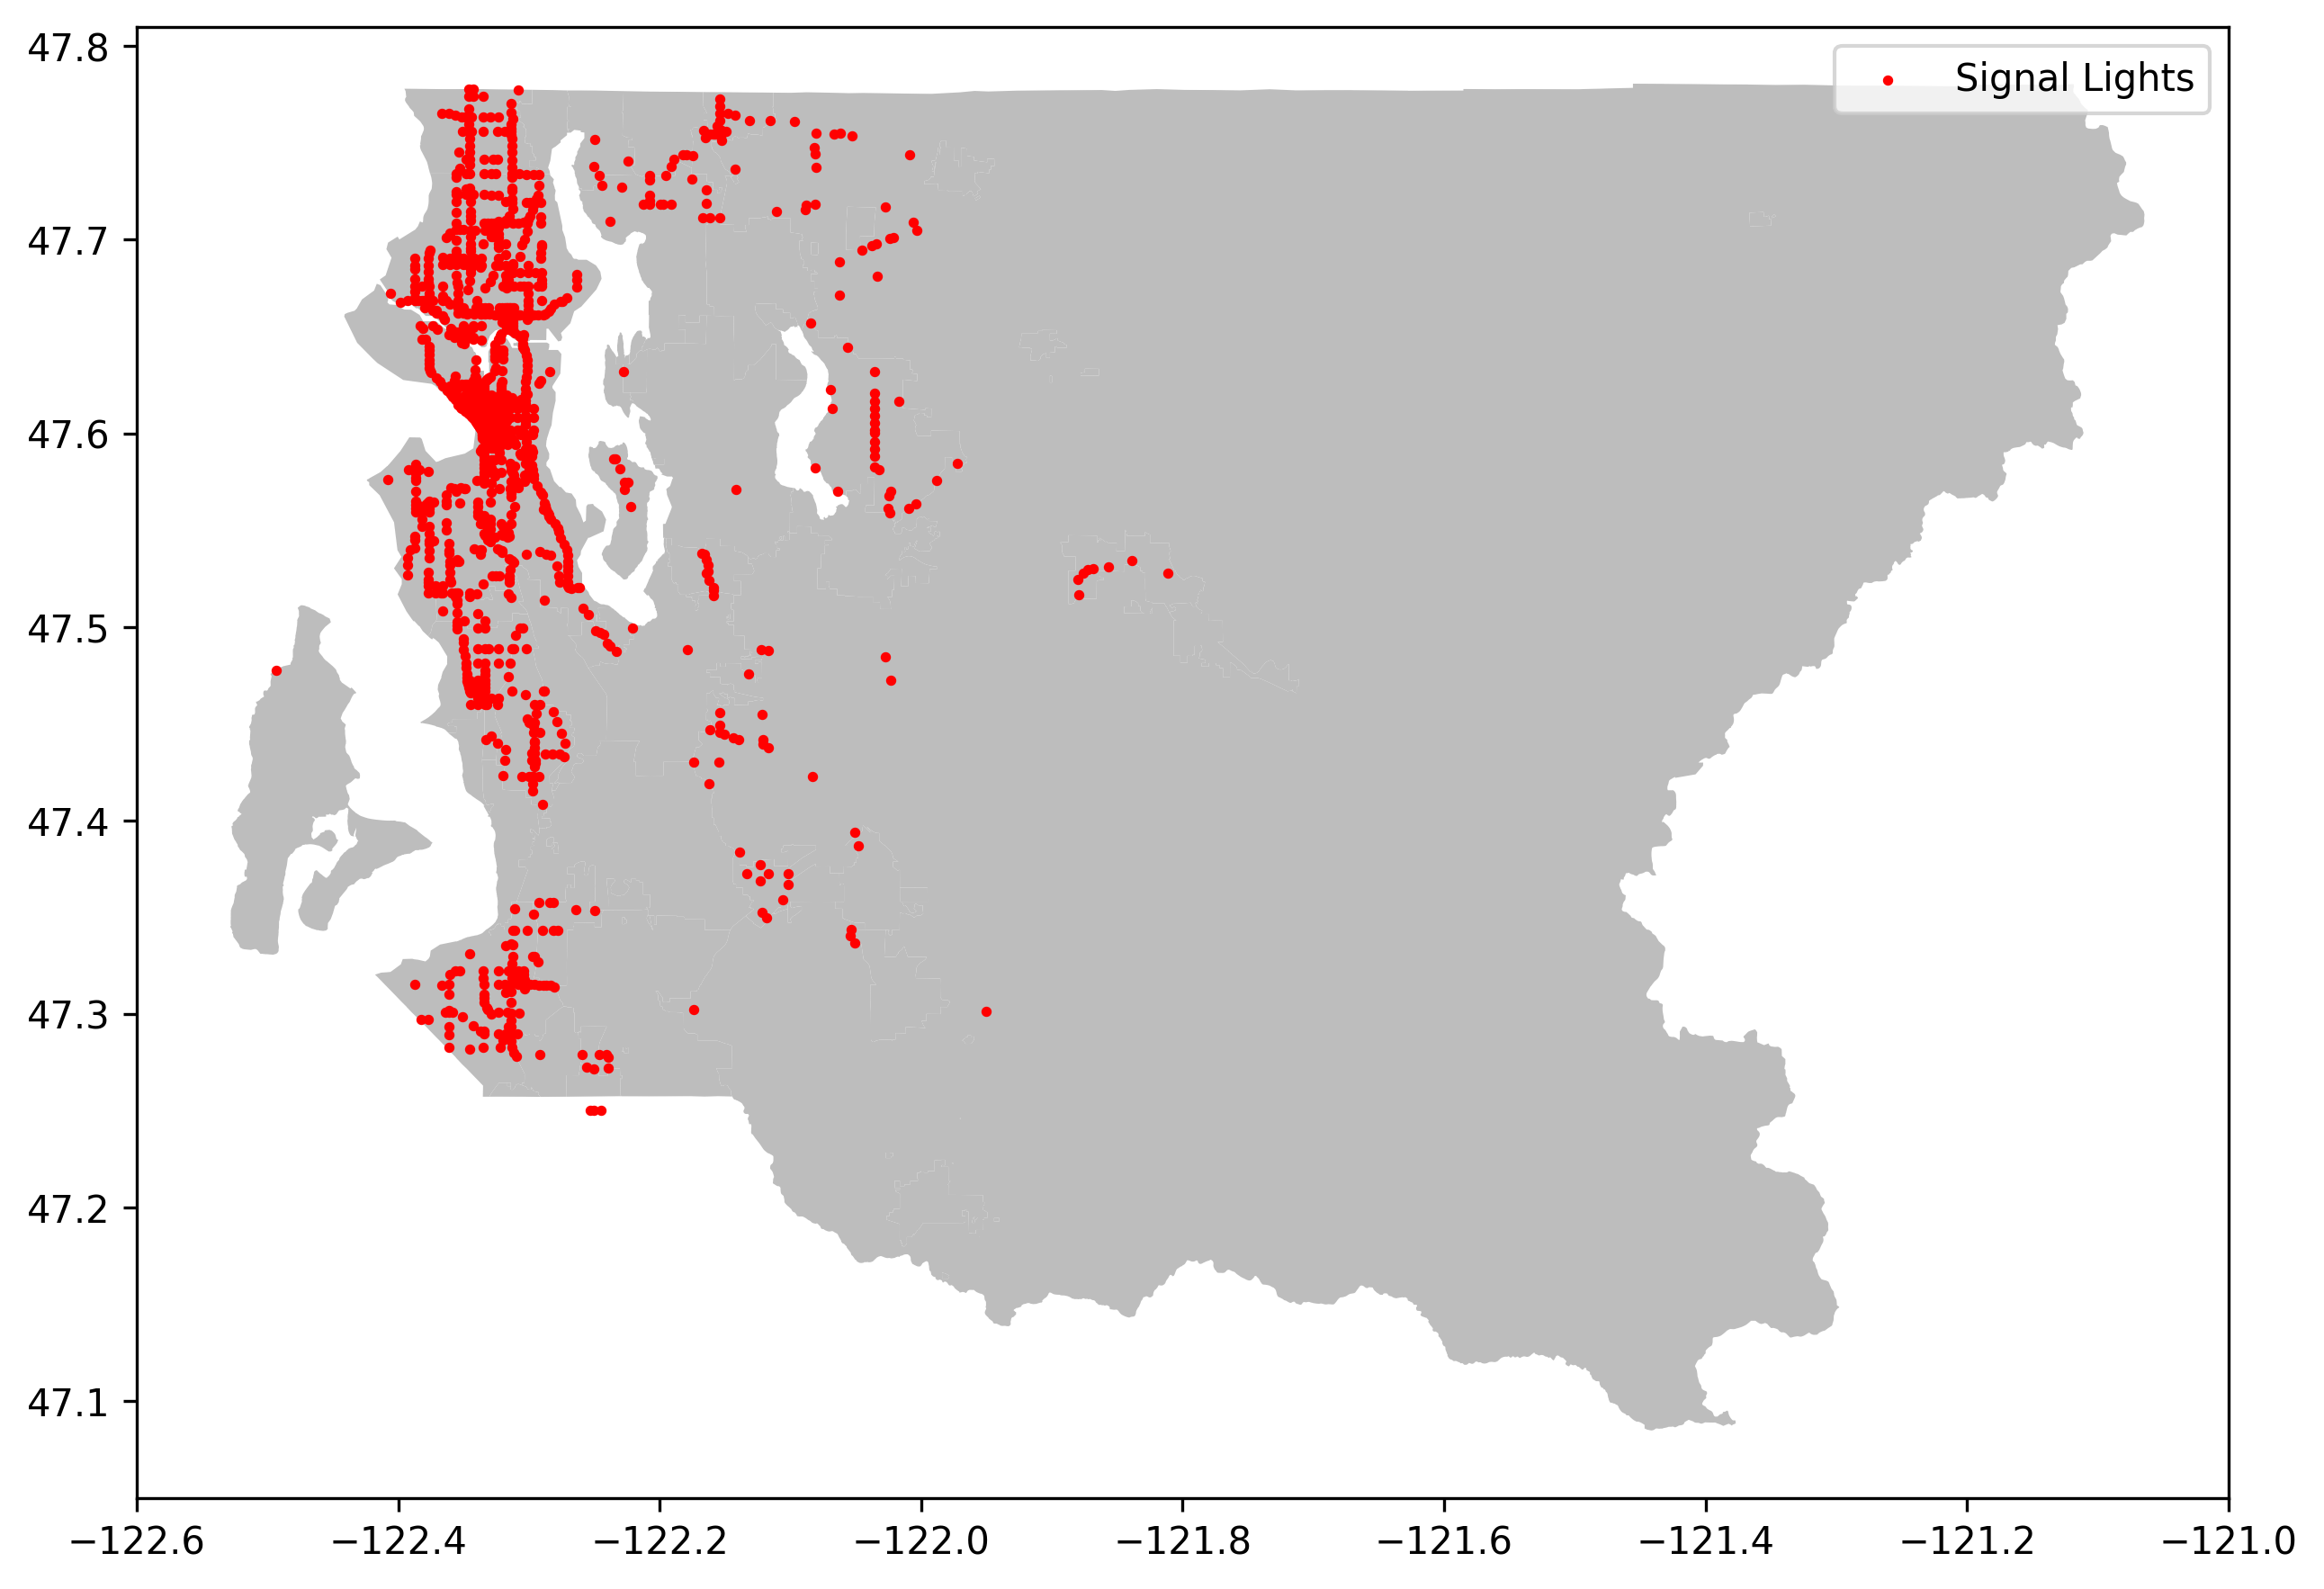

In [3]:
# Load and plot all king county and seattle signals. 

kc_sig = gpd.read_file(route_data_dir + "Signals/KC_Signals.shp")
sea_sig = gpd.read_file(route_data_dir + "Signals/Traffic_Signals.shp")

catsea_sig = sea_sig.filter(['UNITID','geometry'])
catsea_sig['geometry'] = catsea_sig.apply(lambda x: shapely.Point(x['geometry'].geoms[0]),axis=1)
catkc_sig = kc_sig.filter(['SignalID','geometry'])
catsea_sig = catsea_sig.rename(columns={"UNITID":"SIGNAL_ID"})
catsea_sig['SIGNAL_ID'] = catsea_sig['SIGNAL_ID'].apply(lambda x: x if type(x) == type(1) else int(x.split("-")[1])*113)
signals = gpd.GeoDataFrame(pd.concat([catsea_sig,catkc_sig]))

fig, ax = blank_kc_canvas()
signals.plot(ax=ax, c='red',markersize=3, zorder=5)
ax.legend(["Signal Lights"])
plt.show()

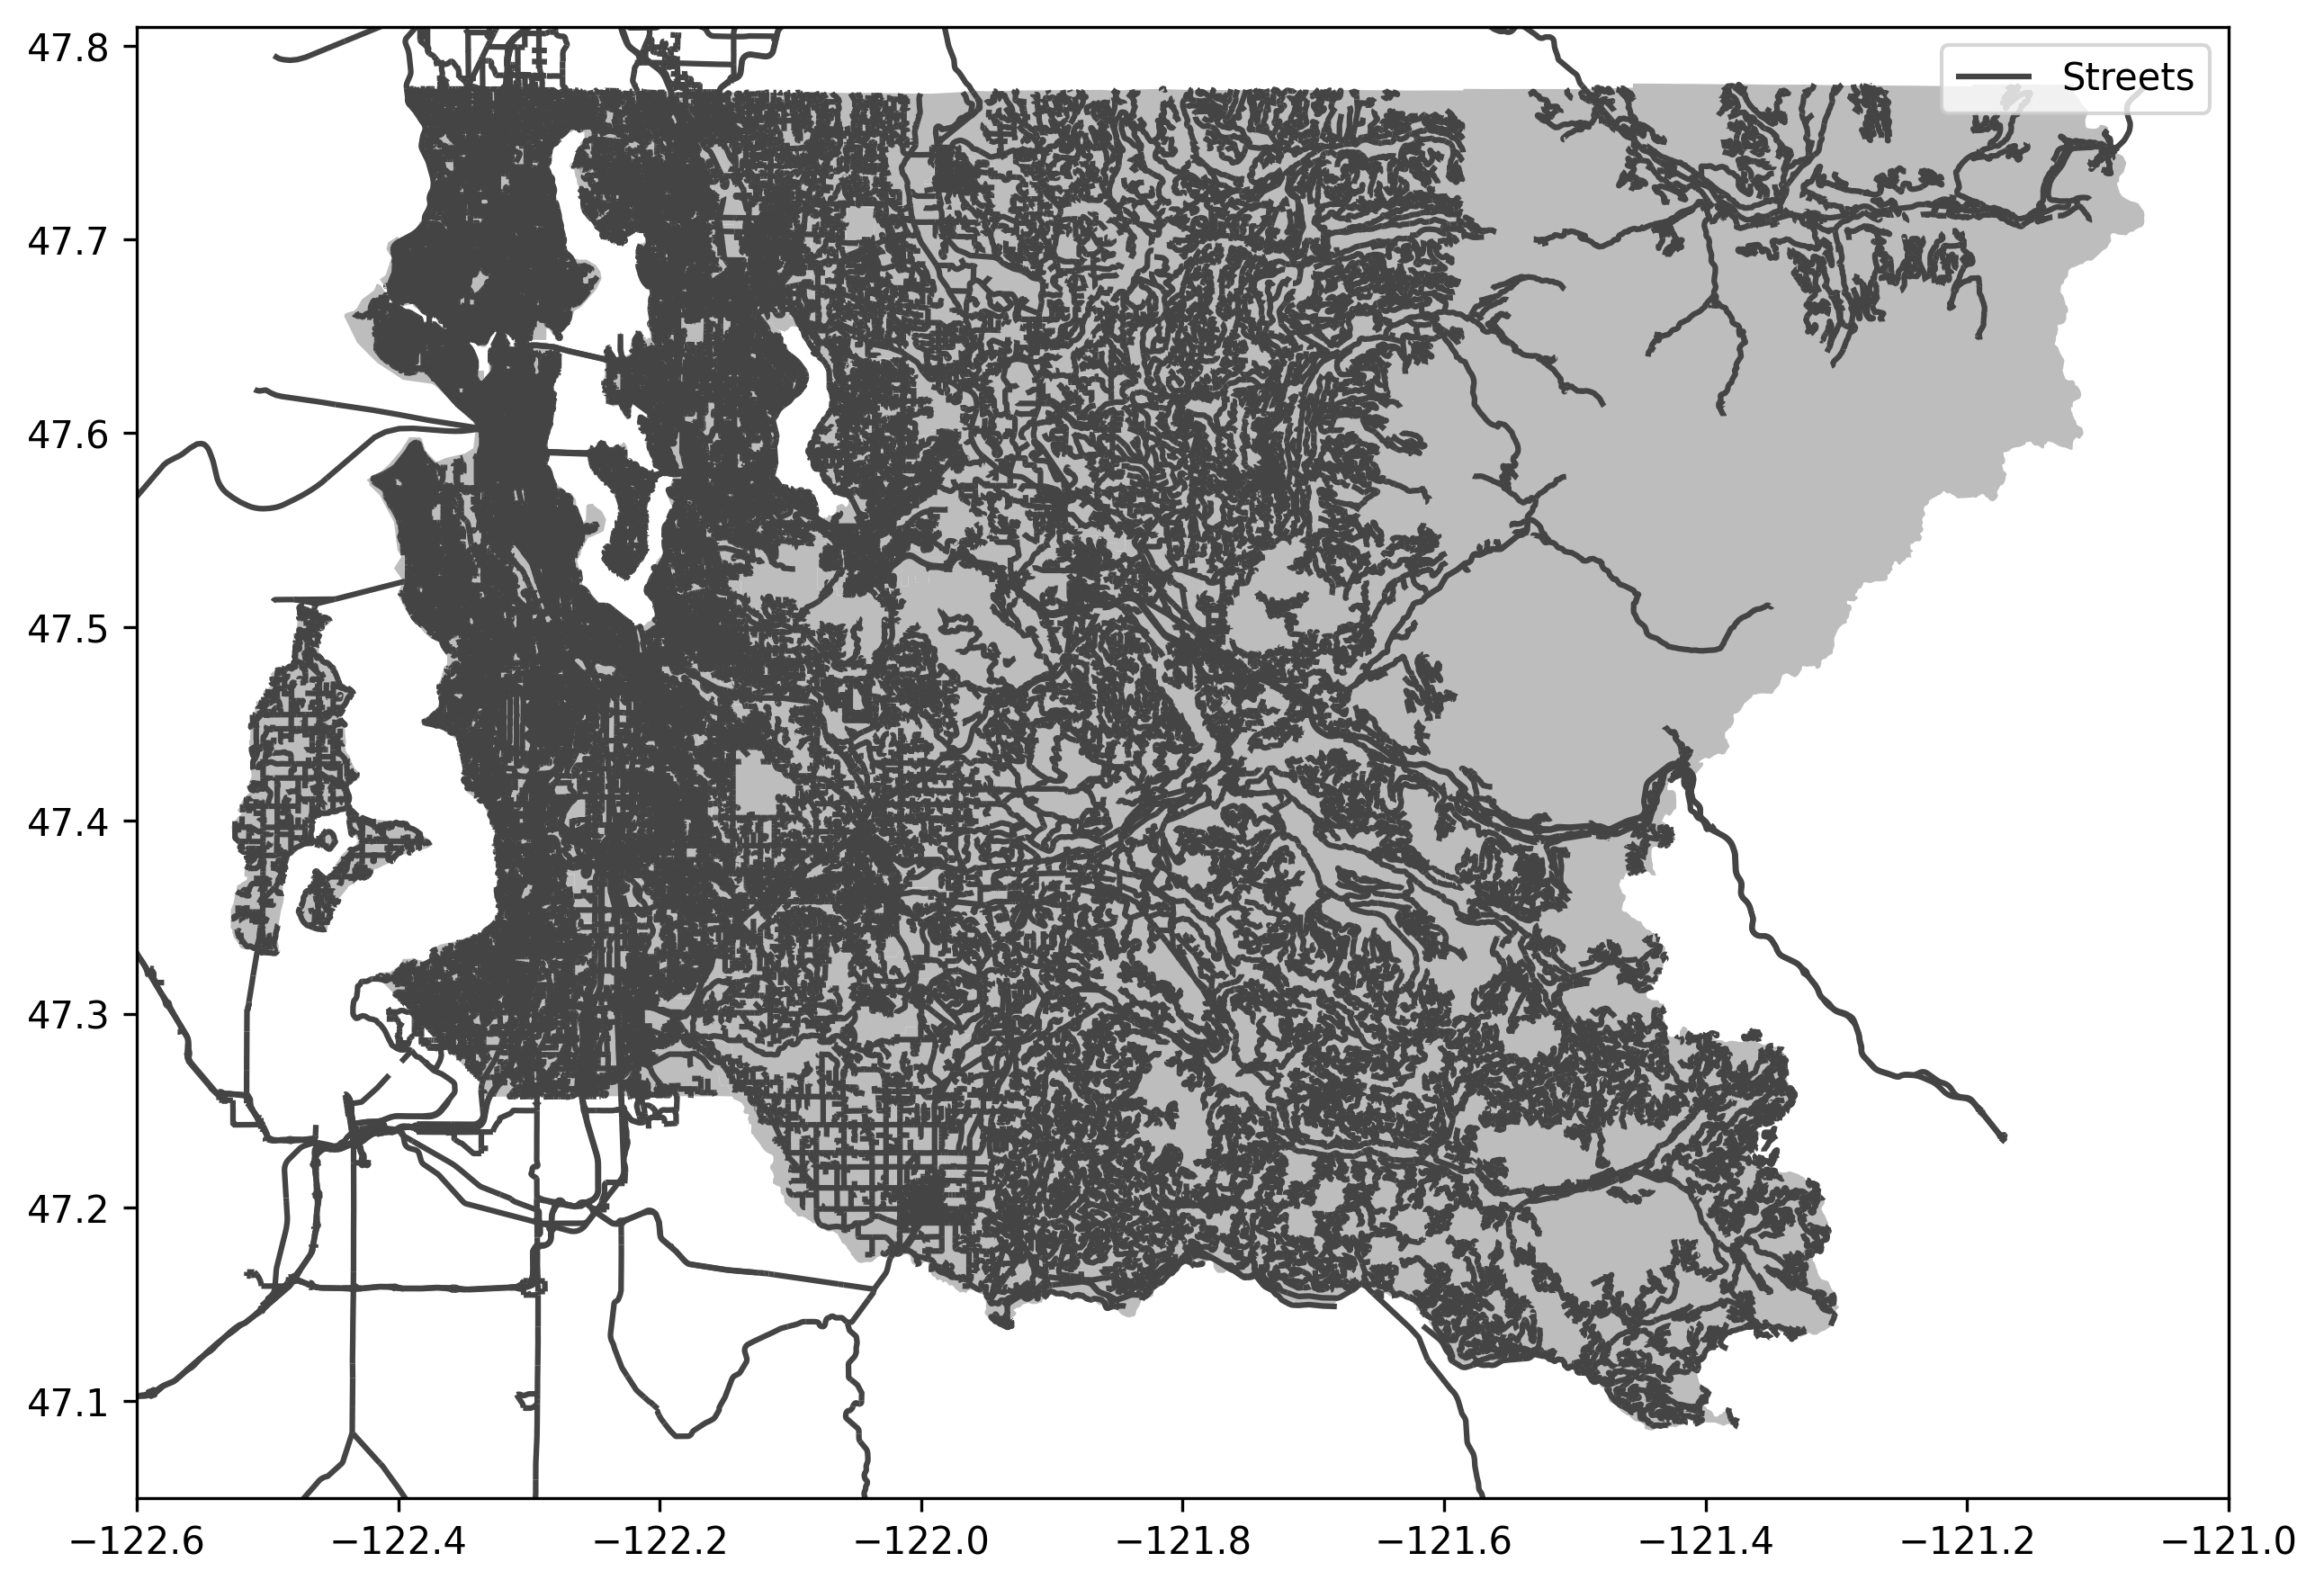

In [4]:
# Load and plot all street data.
kc_lim = pio.read_dataframe(route_data_dir +"Seattle_Streets/KCM_Streets.shp")
fig, ax = blank_kc_canvas()
kc_lim.plot(ax=ax, color='#444444')
ax.legend(["Streets"])
plt.show()

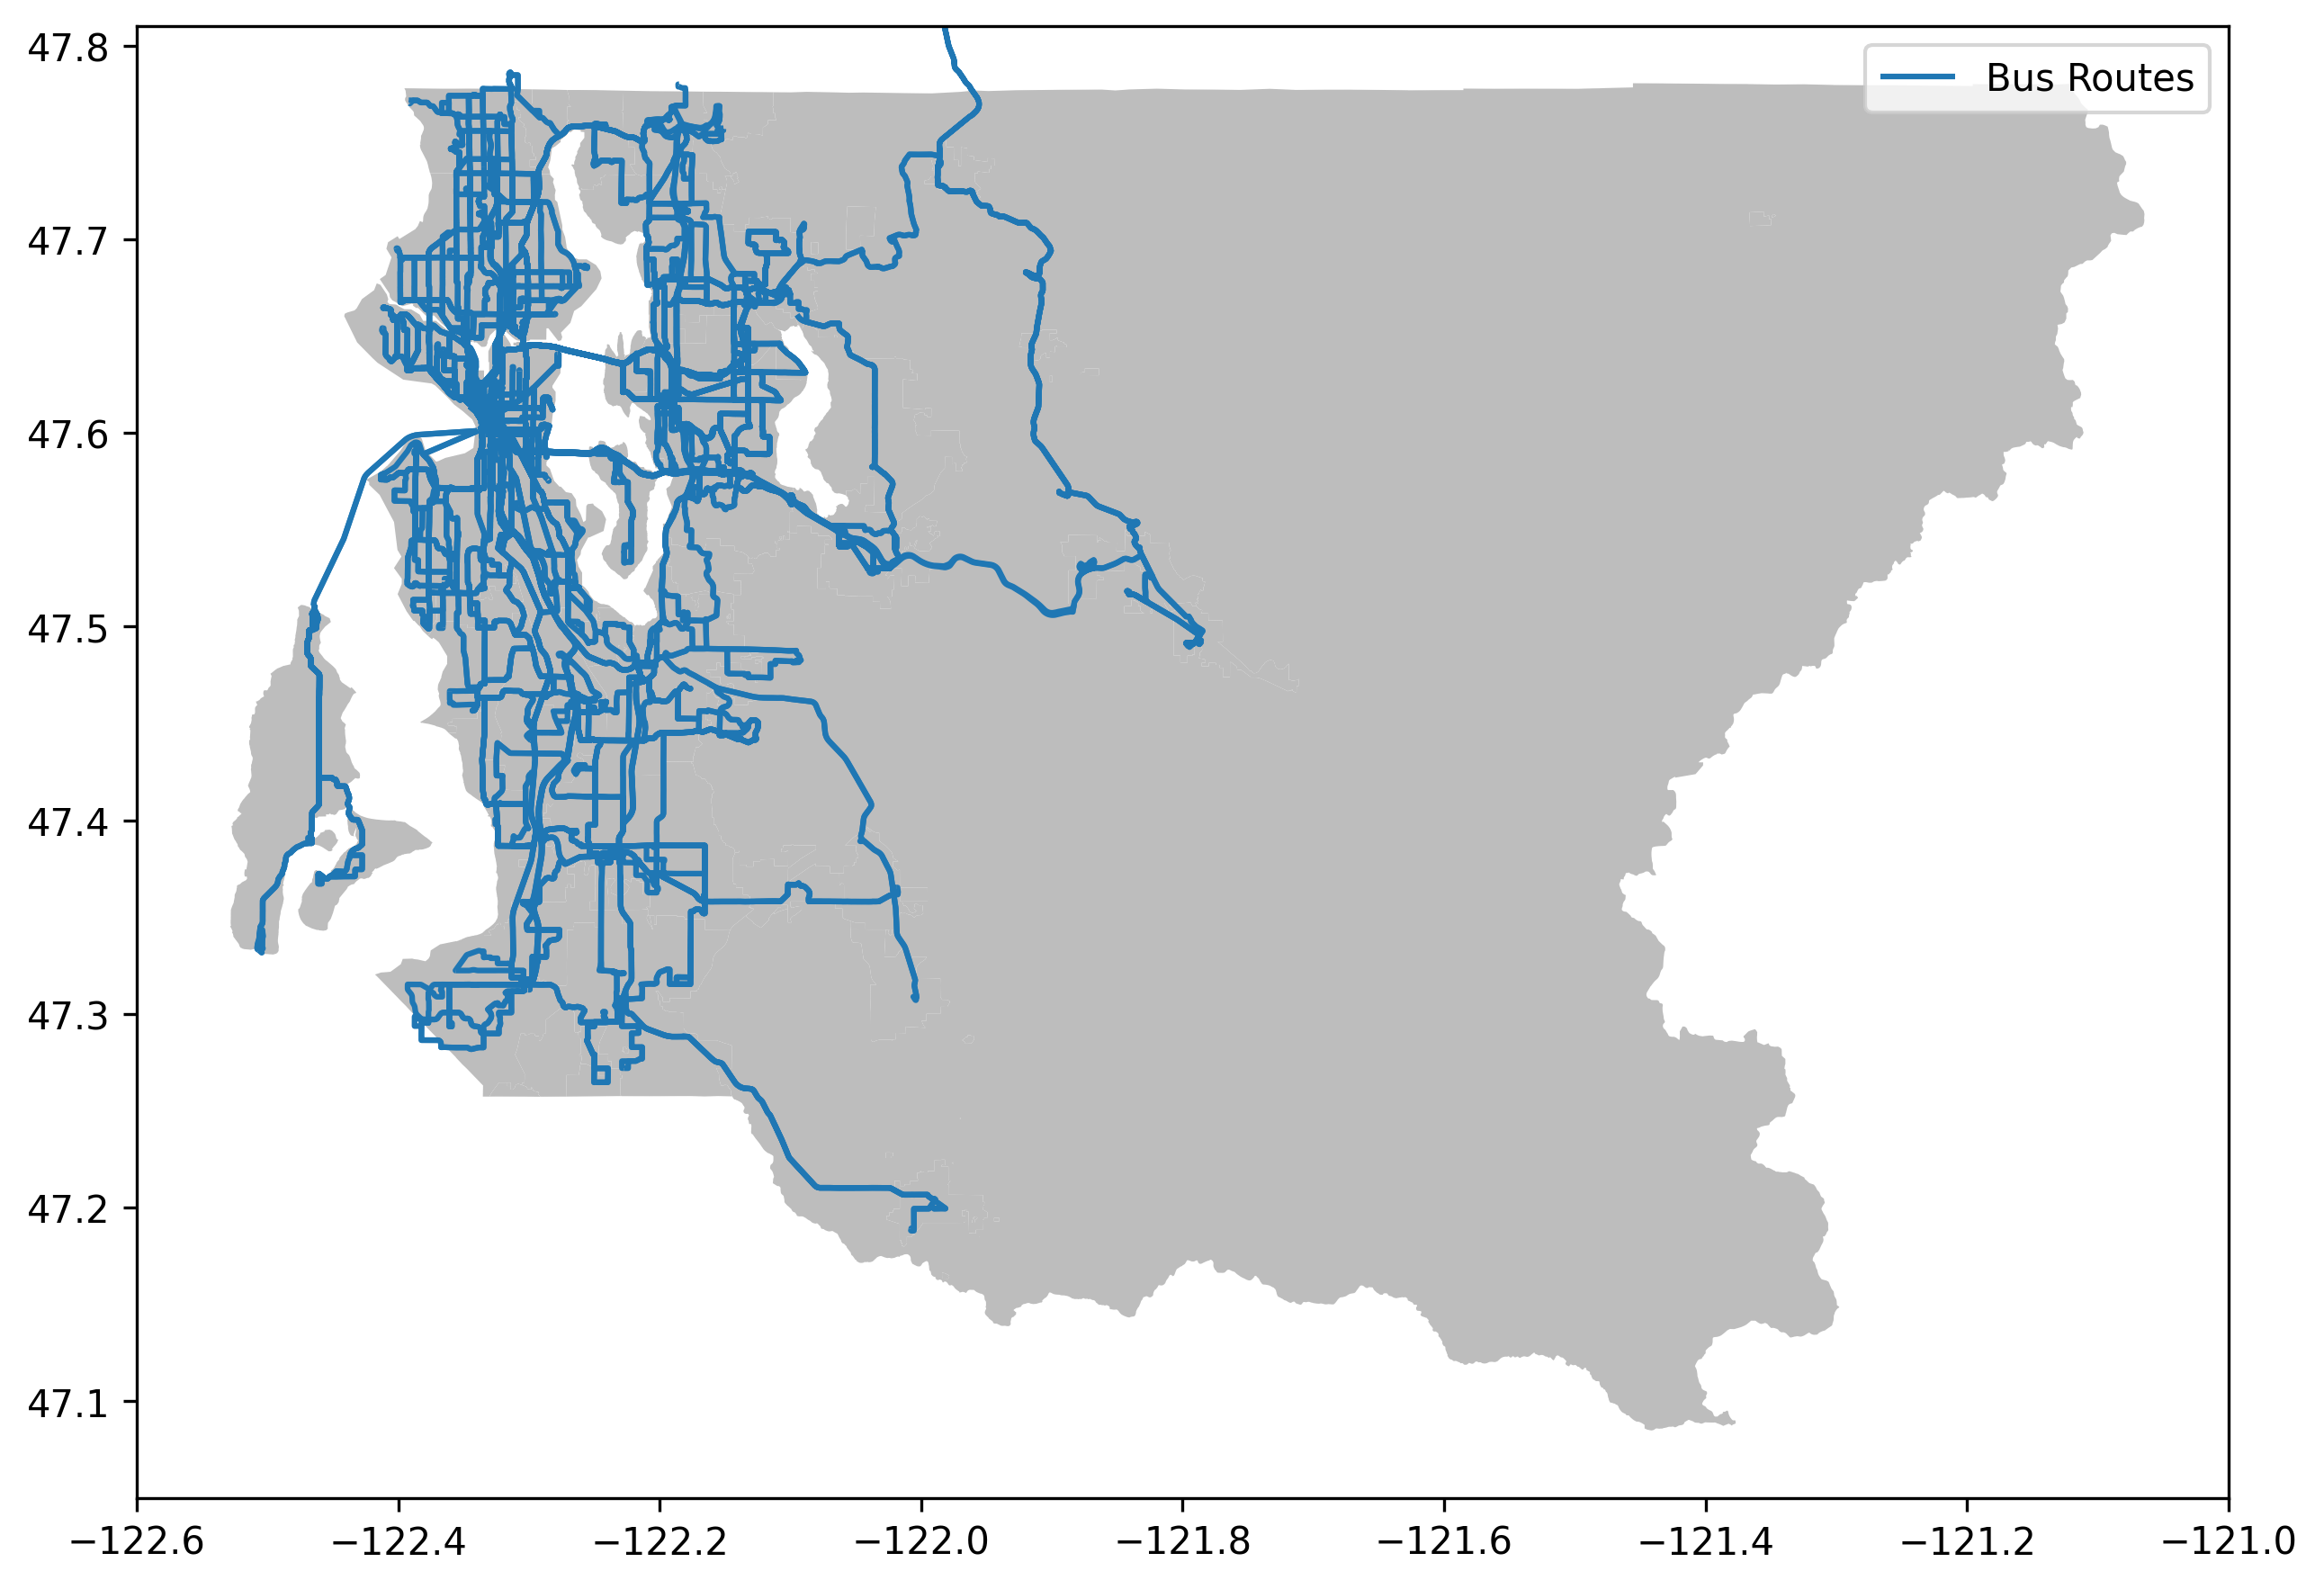

In [5]:
# Load and plot the bus routes.

shapes = pd.read_csv(route_data_dir + "shapes.txt").groupby('shape_id')

data = []
for shape in shapes.groups:
    shape_data = shapes.get_group(shape)
    geometry = shape_data.apply(lambda x: shapely.Point(x['shape_pt_lon'], x['shape_pt_lat']), axis=1)
    data.append({'shape':shape,'geometry':shapely.LineString(geometry)})
shape_routes = gpd.GeoDataFrame(data).set_crs(epsg=4326)

fig, ax = blank_kc_canvas()
shape_routes.plot(ax=ax)
ax.legend(["Bus Routes"])
plt.show()

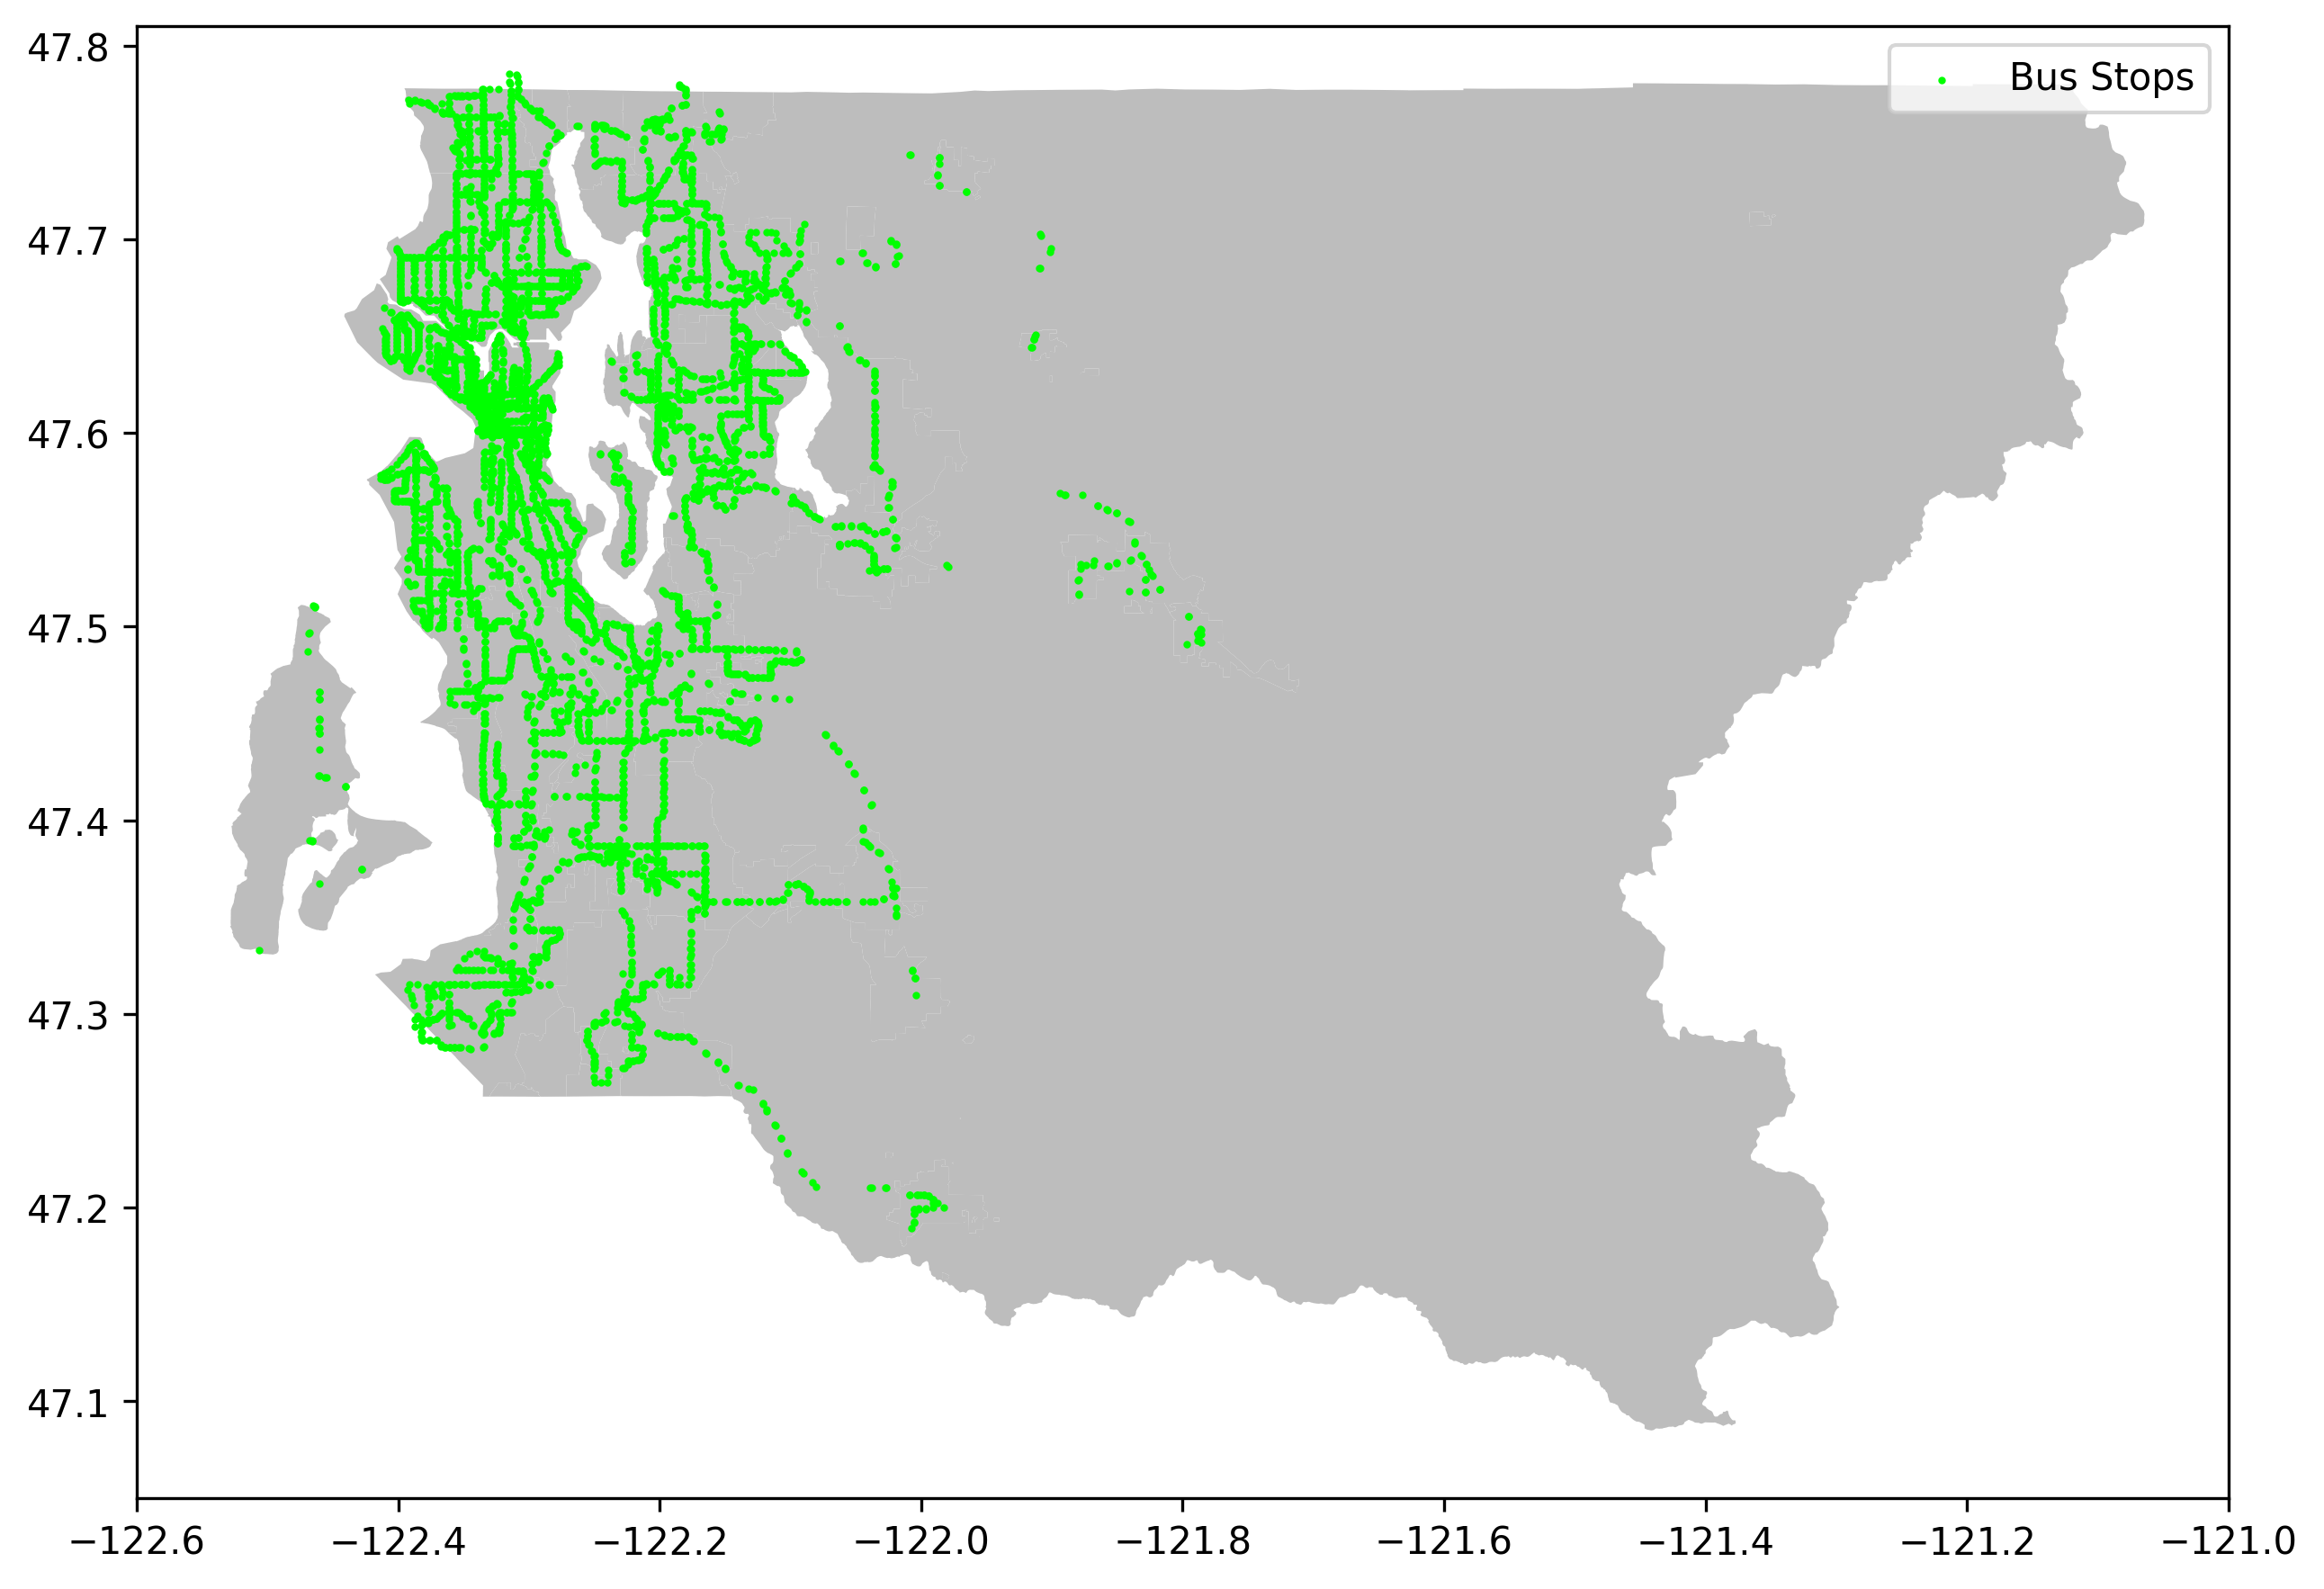

In [6]:
# Load and plot the bus stops.

bus_stops = pd.read_csv(route_data_dir + "stops.txt")
bus_stops['geometry']=bus_stops.apply(lambda x: shapely.Point(x['stop_lon'],x['stop_lat']), axis=1)
bus_stops = gpd.GeoDataFrame(bus_stops.filter(['stop_id','geometry'])).set_crs(epsg=4326)

fig, ax = blank_kc_canvas()
bus_stops.plot(ax=ax, color="lime", zorder = 10, markersize=1)
ax.legend(["Bus Stops"])
plt.show()

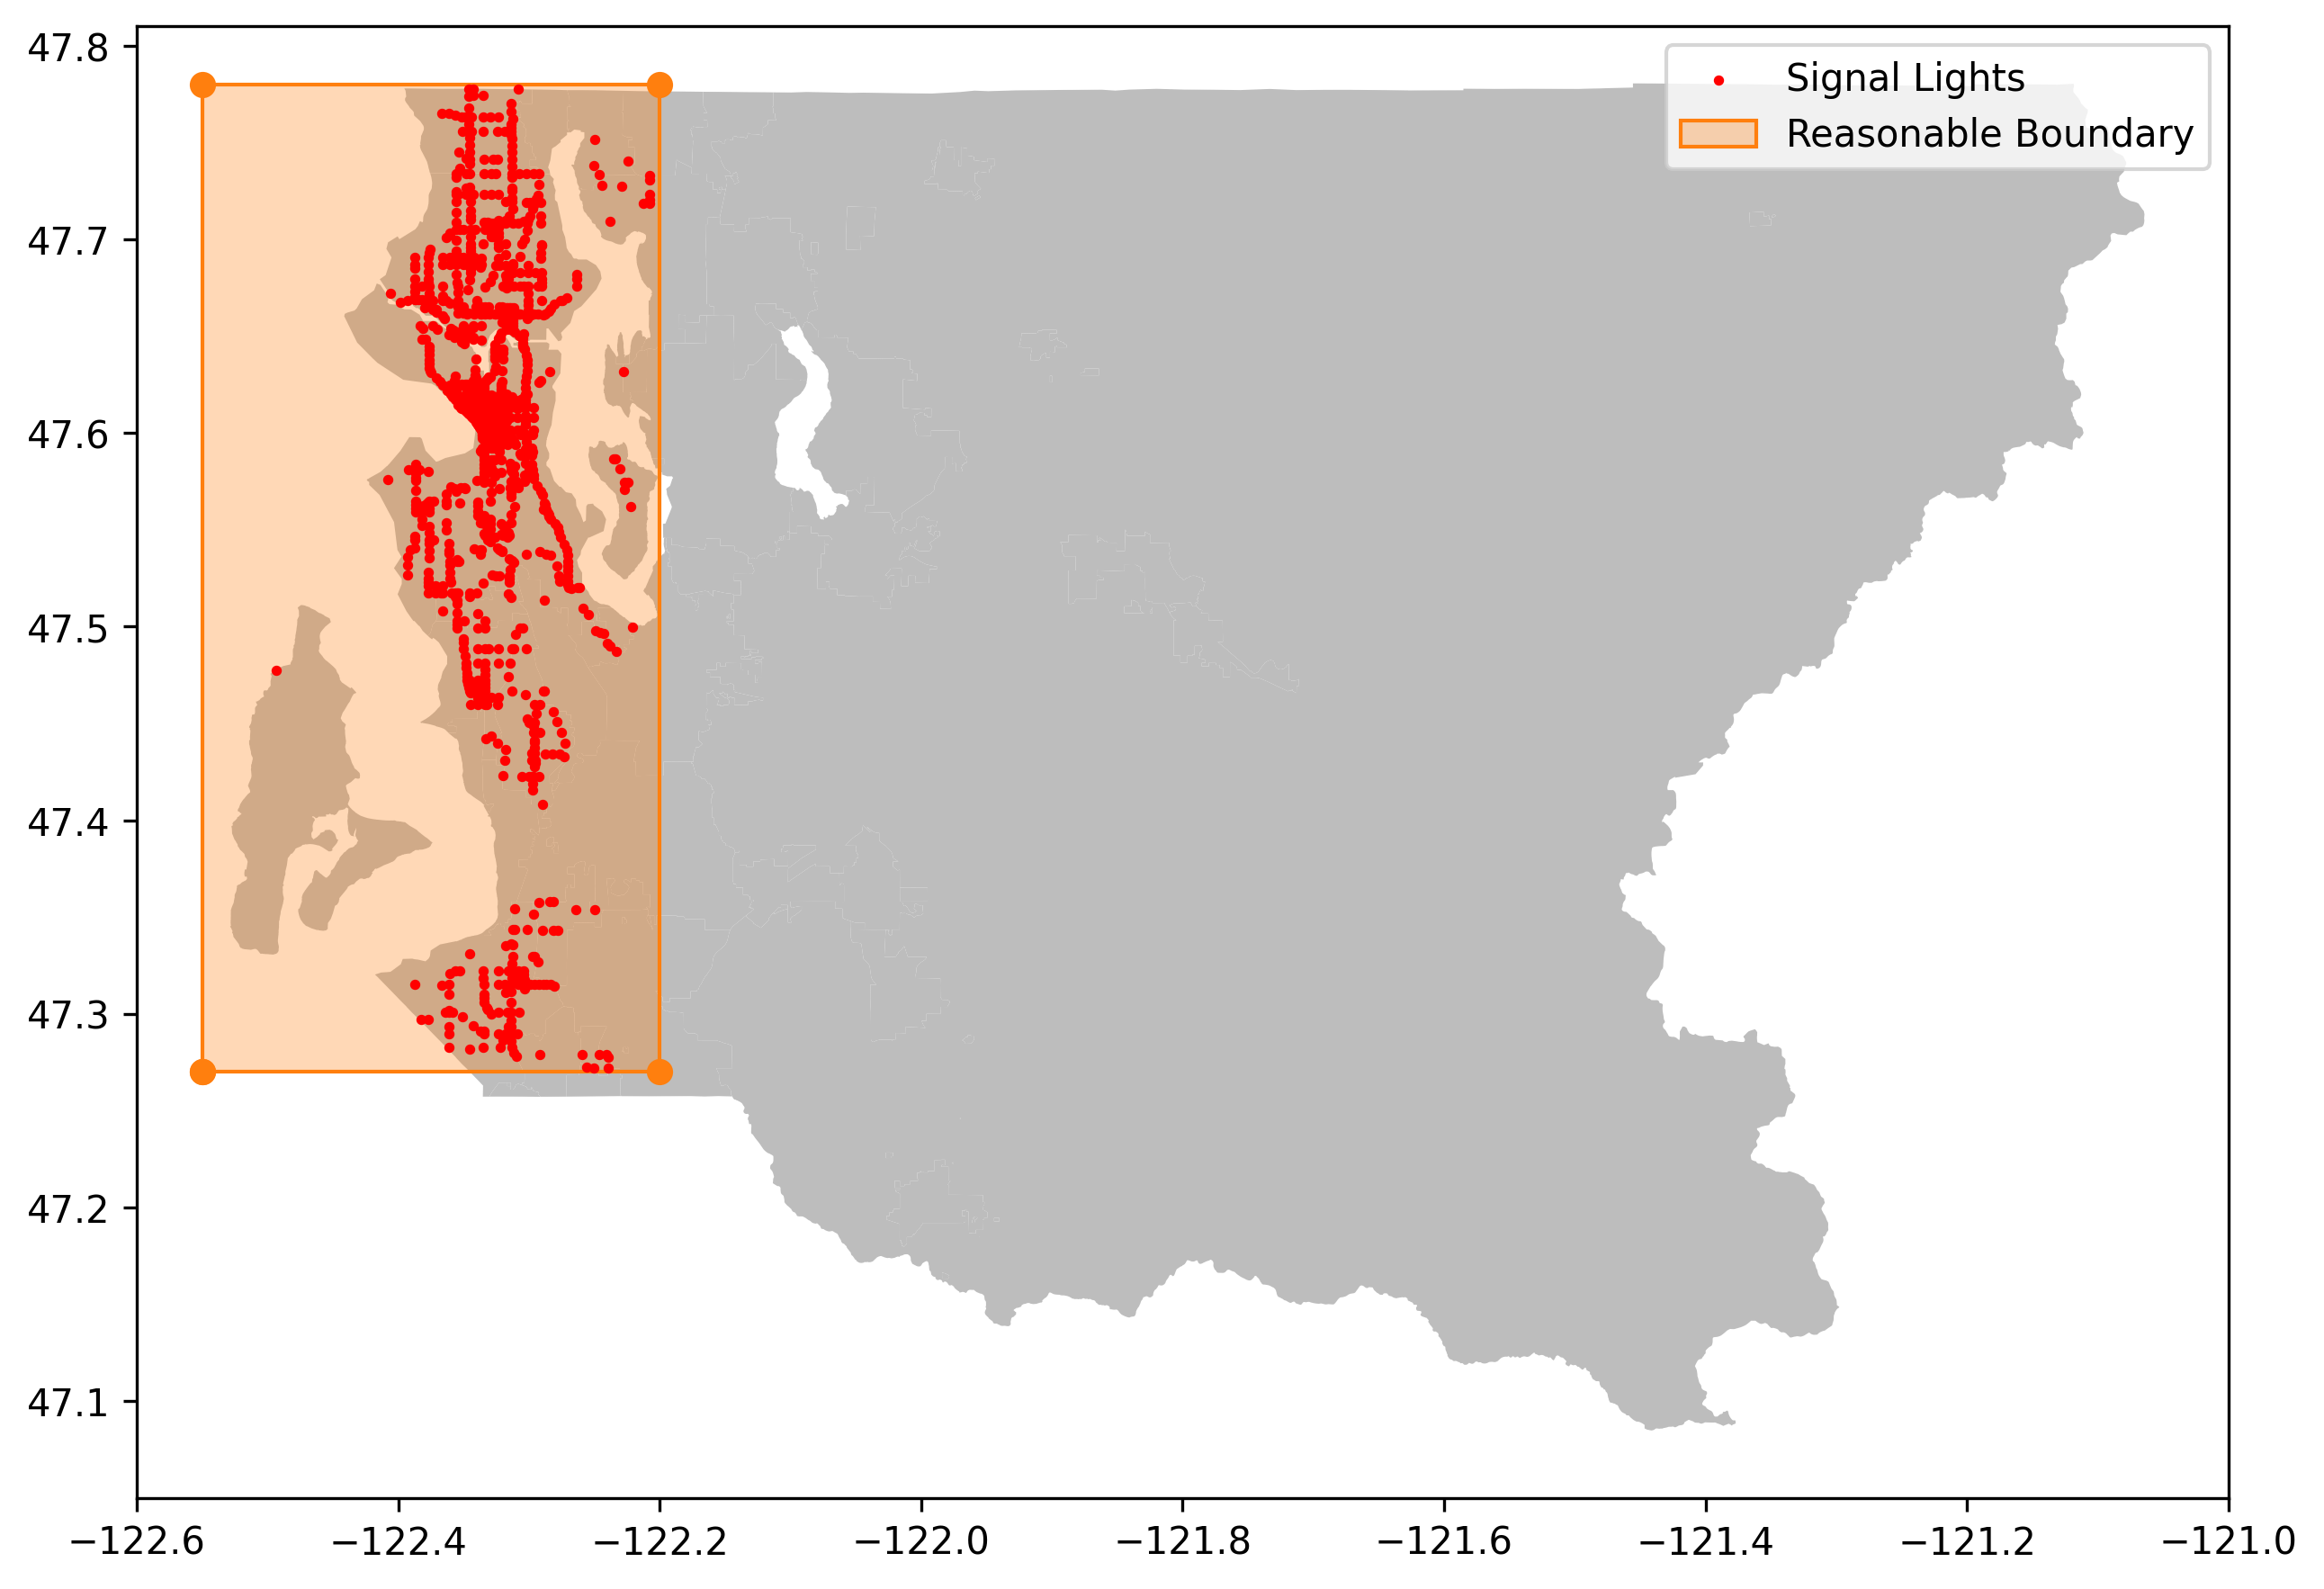

In [7]:
# Demonstrate the bounds fit the data decently enough, then plot
corners = shapely.LineString([(-122.55,47.78),(-122.2,47.27)])
bounds = gt.get_bounding_box(corners)
fig, ax = blank_kc_canvas()
bound_signals = bind_geodata(signals, bounds)
bound_signals.to_file(route_data_dir+"Signals/bound_KCM_signals.shp", driver='ESRI Shapefile')
bound_signals.plot(ax=ax, c='red',markersize=3, zorder=5)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Signal Lights","Reasonable Boundary"])
plt.show()

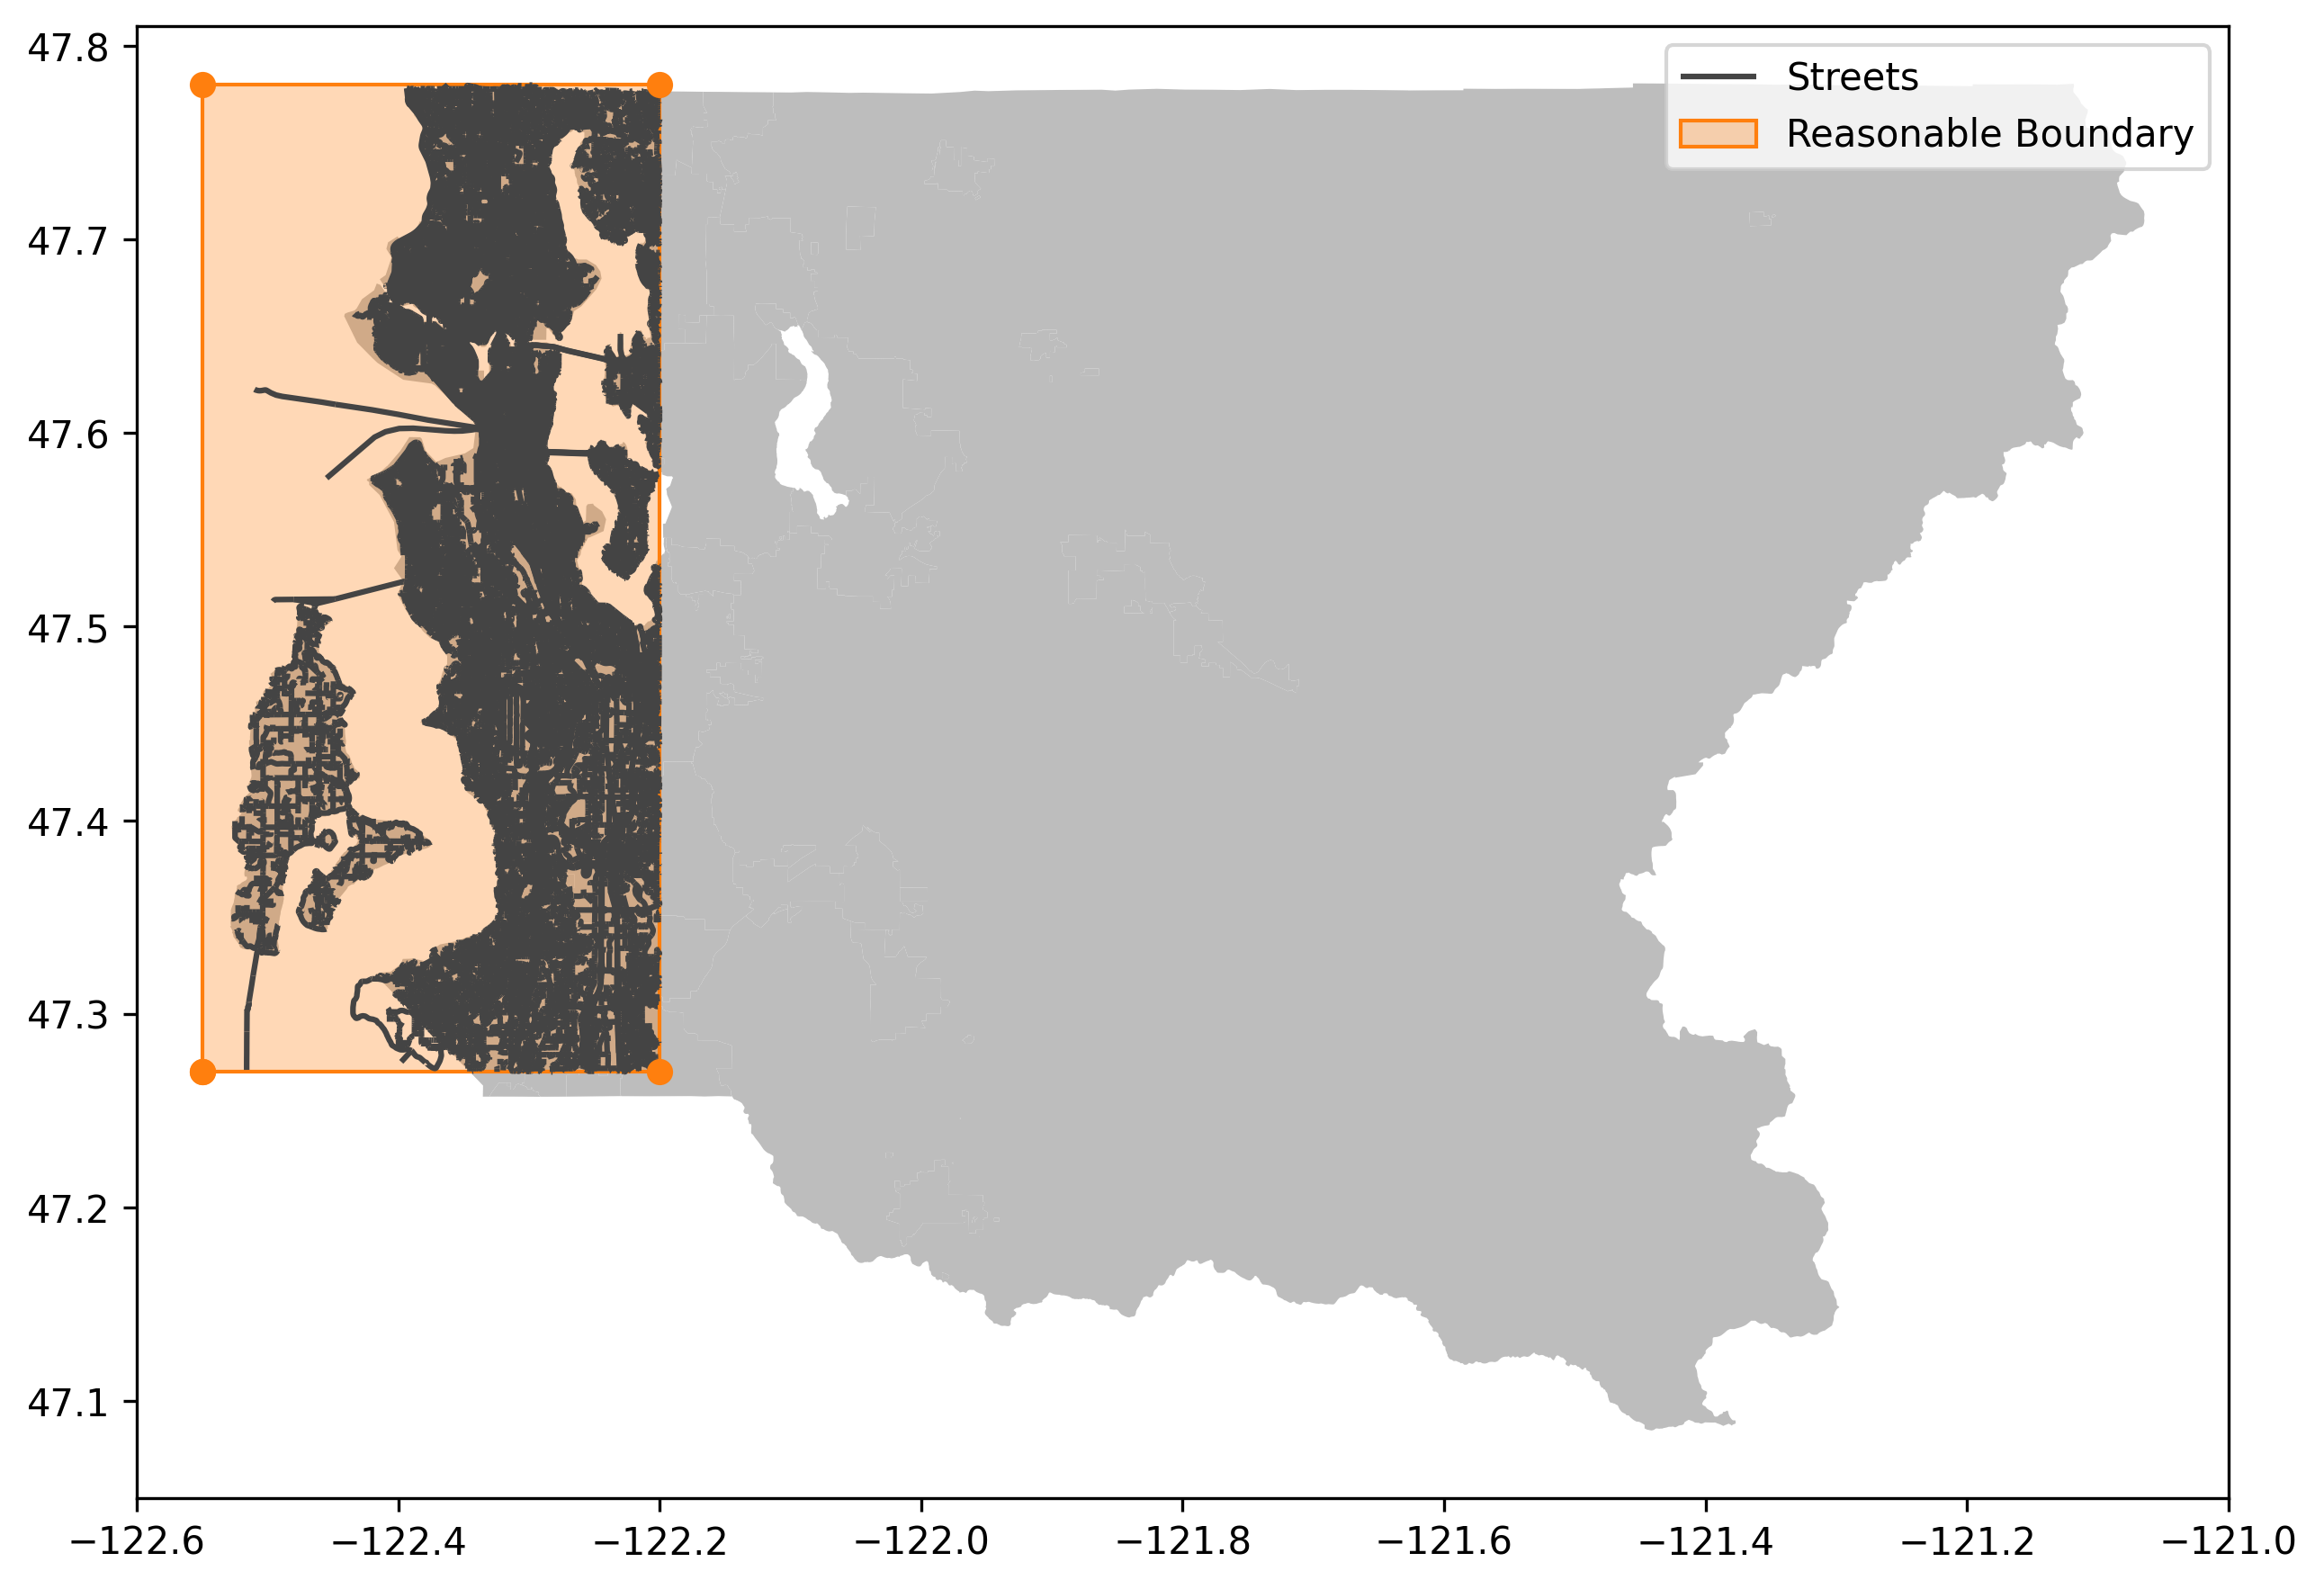

In [8]:
# re-plot with bounds
fig, ax = blank_kc_canvas()
bound_kc_lim = bind_geodata(kc_lim, bounds, how='contains')
bound_kc_lim = bound_kc_lim.filter(['SPEED_LIM', "geometry"])
bound_kc_lim.to_file(route_data_dir+"Seattle_Streets/bound_KCM_Streets.shp", driver='ESRI Shapefile')
bound_kc_lim.plot(ax=ax, color='#444444')
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Streets","Reasonable Boundary"])
plt.show()

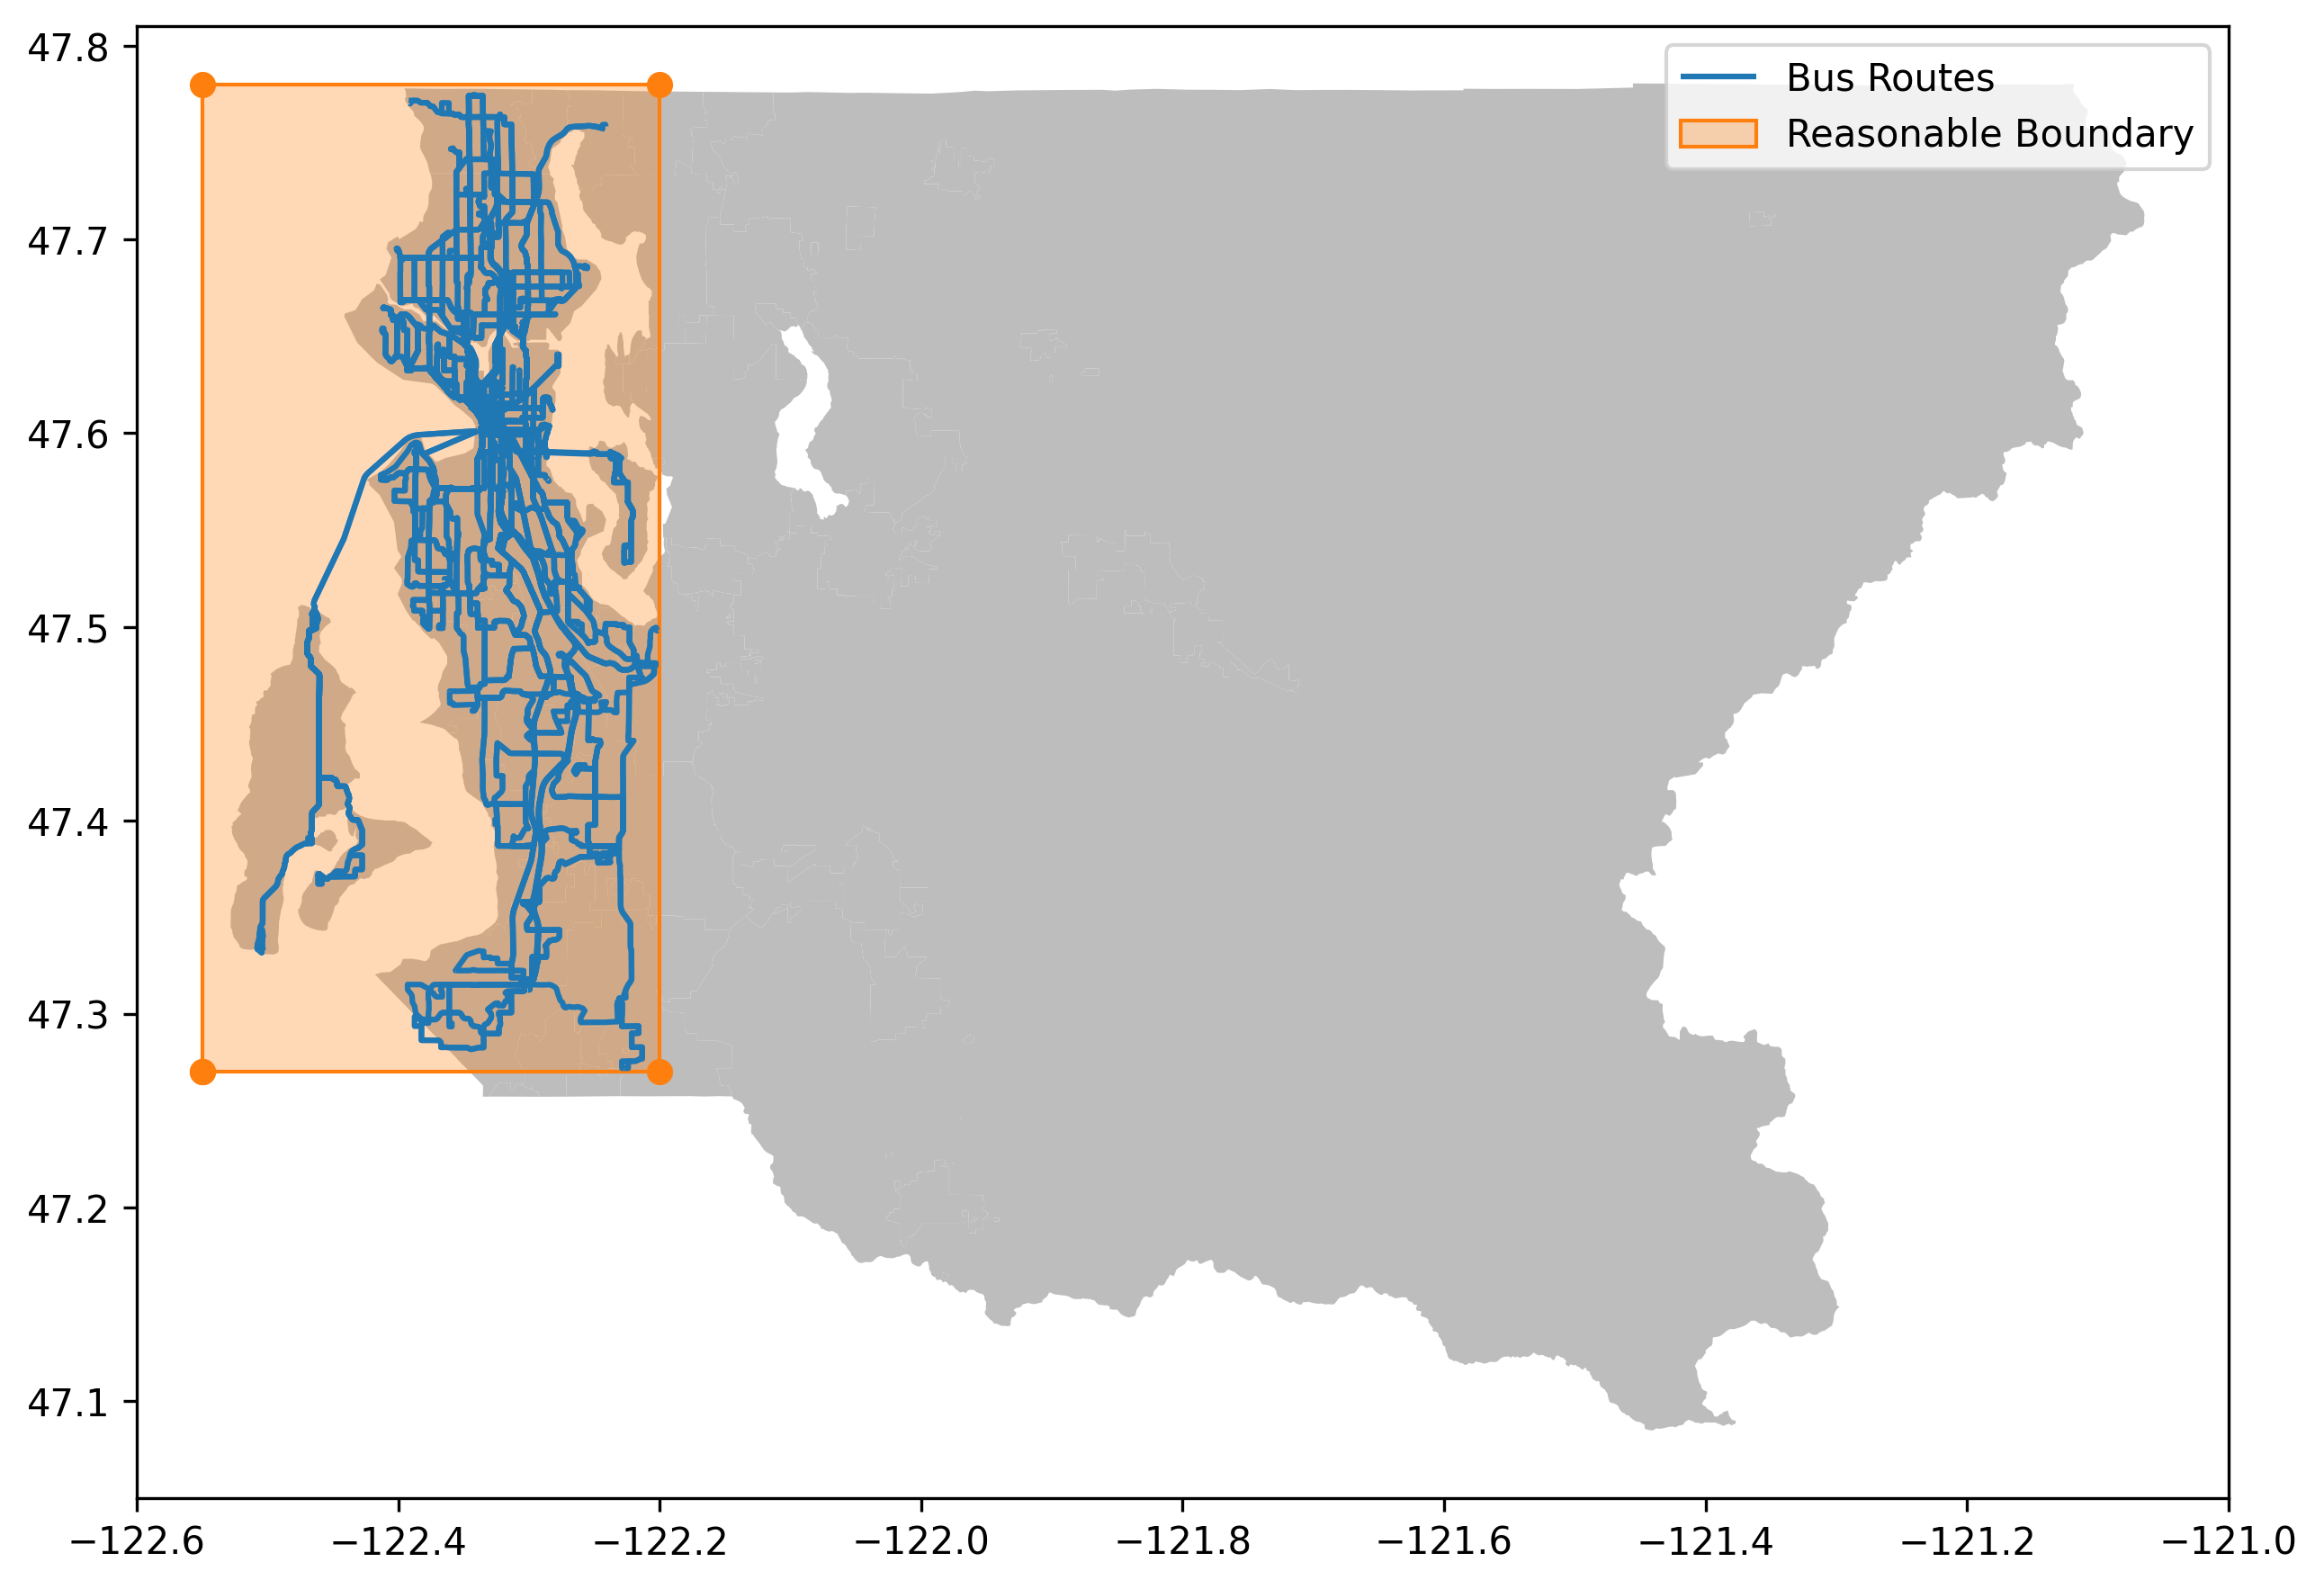

In [9]:
# re plot the routes with the bounds.
fig, ax = blank_kc_canvas()
bound_shape_routes = bind_geodata(shape_routes, bounds, how='contains')
bound_shape_routes.plot(ax=ax)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Bus Routes","Reasonable Boundary"])
plt.show()

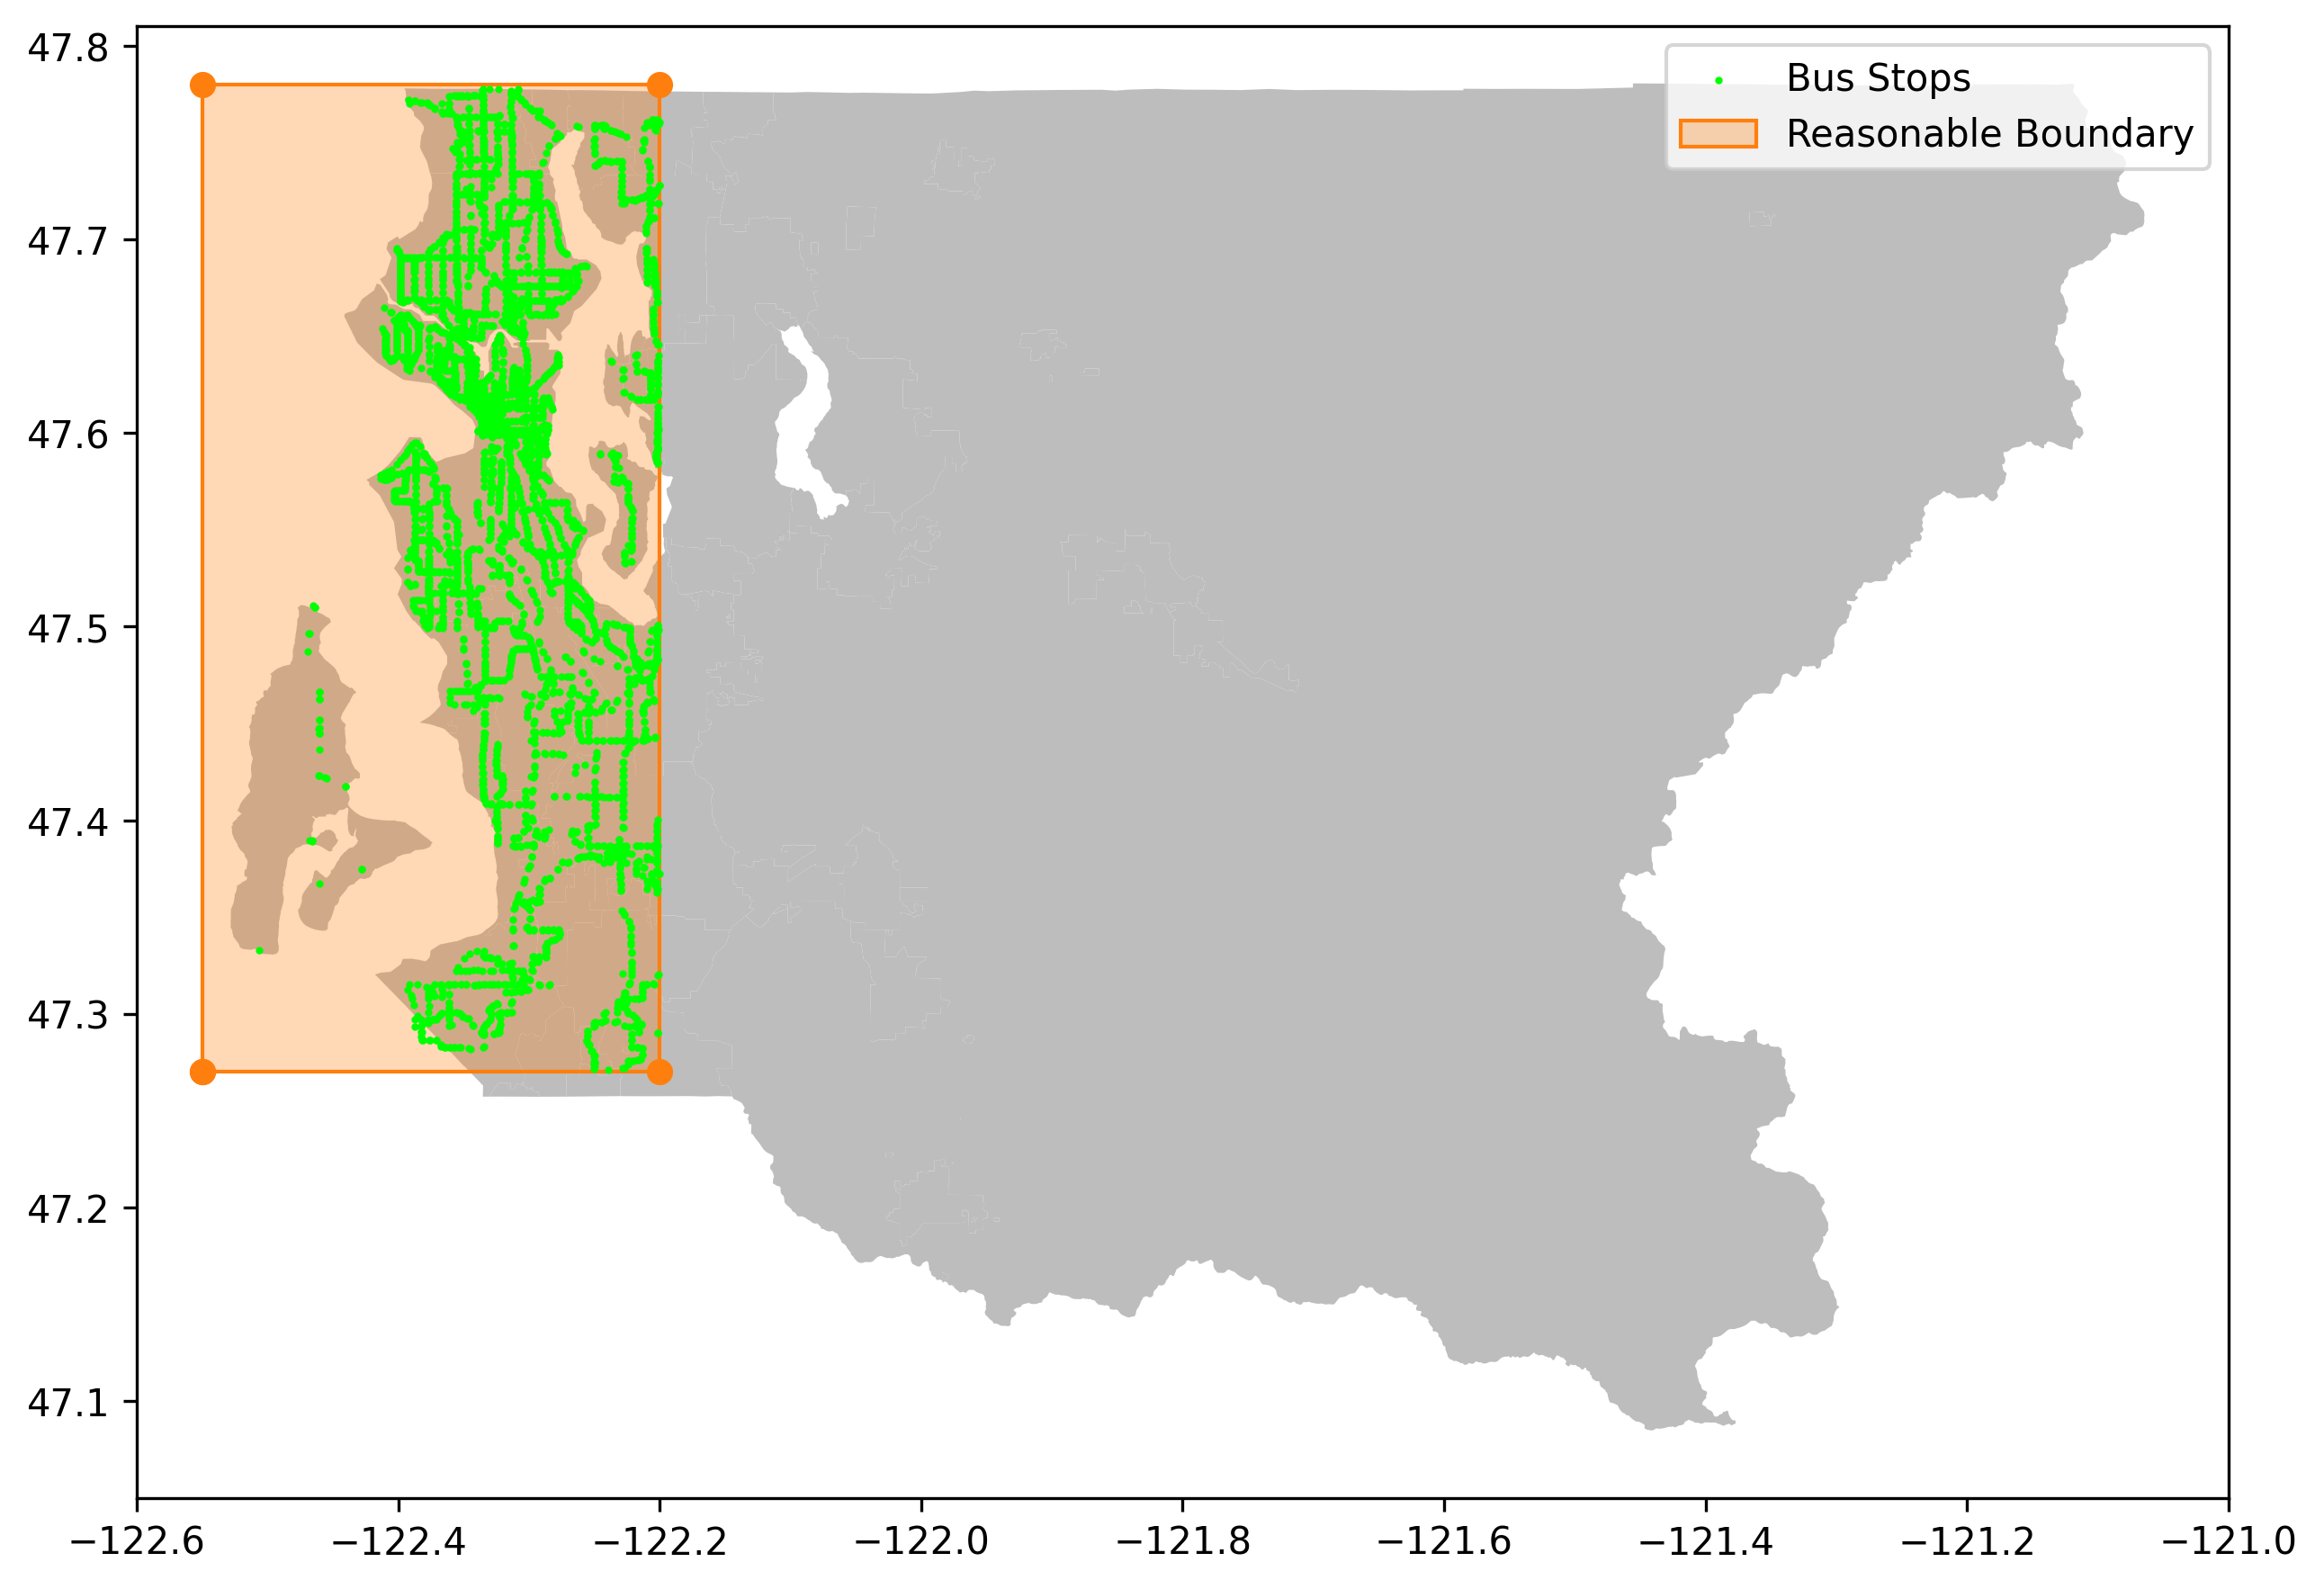

In [10]:
# Re-plot the routes with bounds
fig, ax = blank_kc_canvas()
bound_bus_stops = bind_geodata(bus_stops, bounds)
bound_bus_stops.plot(ax=ax, color="lime", zorder = 10, markersize=1)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Bus Stops", "Reasonable Boundary"])
plt.show()

In [11]:
# extract ridership data for full factorial combinations
formatted_rider_data = kqt.calculate_expected_ridership(ridership_data_path)

# And also get all the routes with ridership data while converting the values to string for inter-operability.
route_options = list(pd.Series(formatted_rider_data['rt'].unique()).apply(str))

In [12]:
# Get all the route ids based on the routes in the bounds
route_ids = []
for option in route_options:
    try:
        route_id = kqt.query_route_id(option, route_data_dir + "routes.txt")
        shapes = kqt.query_possible_shapes(route_id, route_data_dir+"trips.txt")
        route_ids.append({"shortname":option,"route_id":route_id, "shape":shapes, "direction":[0,1]})
        
    except: 
        print("{} not found.".format(option))
route_ids = pd.DataFrame(route_ids)

15 not found.
18 not found.
19 not found.
26 not found.
29 not found.
37 not found.
41 not found.
47 not found.
55 not found.
63 not found.
64 not found.
71 not found.
73 not found.
74 not found.
76 not found.
77 not found.
78 not found.
114 not found.
116 not found.
120 not found.
121 not found.
122 not found.
123 not found.
143 not found.
154 not found.
157 not found.
158 not found.
159 not found.
164 not found.
166 not found.
167 not found.
169 not found.
178 not found.
179 not found.
180 not found.
186 not found.
190 not found.
192 not found.
197 not found.
200 not found.
201 not found.
214 not found.
216 not found.
217 not found.
219 not found.
232 not found.
234 not found.
235 not found.
236 not found.
237 not found.
238 not found.
243 not found.
244 not found.
248 not found.
252 not found.
268 not found.
277 not found.
301 not found.
304 not found.
308 not found.
309 not found.
312 not found.
316 not found.
330 not found.
342 not found.
347 not found.
355 not found.
373 not foun

In [13]:
importlib.reload(op)
# make unique rows per shape
route_shapes = route_ids.explode("shape").reset_index(drop=True)

# get the shapes within the bounds
bound_route_options = route_shapes[route_shapes['shape'].isin(bound_shape_routes['shape'].unique())].reset_index(drop=True)
# Create rows for each option
bound_route_options = bound_route_options.explode("direction")

# Load the paths up.
bound_route_options['path'] = bound_route_options.apply(lambda x: route_savepath + 'rt{}_sh{}_d{}.json'.format(x.shortname, x['shape'], x['direction']),axis=1)
bound_route_options = bound_route_options.reset_index(drop=True)

# Load the ridership data
formatted_rider_data = kqt.calculate_expected_ridership(ridership_data_path)
formatted_rider_data['io']=formatted_rider_data['io'].apply(lambda x: 0 if x=='I' else 1)

# Get period ridership for each route option
bound_route_options['rider_dict'] = bound_route_options.apply(lambda x: kqt.get_ridership(x.shortname, x.direction, formatted_rider_data), axis=1)

# Read the bus live data tracking info TODO MAKE VARIABLE
timelog= pd.read_csv('bus_time_tracking2.csv')

# load up the individual bus types
timelog['btype'] = timelog[timelog.apply(lambda x: len(x['bus']), axis=1) == 4].apply(lambda x: kqt.bus_type_finder(int(x.bus)), axis=1)

# Pass the bus types to each route instance
bound_route_options['bus'] = bound_route_options.apply(lambda x: timelog.groupby('rt').get_group(x['route_id'])['btype'].unique() if x['route_id'] in timelog.groupby('rt').groups else ["NA"], axis=1)

# create individual instances for each bus type a route can take
bound_route_options = bound_route_options.explode('bus').reset_index(drop=True)

# Remove any instances with No bus model information
prepped_routes = bound_route_options[bound_route_options['bus'].apply(lambda x: x != "NA")].reset_index(drop=True)

# Conver busses to bus object paths
prepped_routes['bus'] = prepped_routes['bus'].apply(lambda x: bus_save_path + '{}.txt'.format(x))

# Set up the minimum and maximum for ridership
prepped_routes['ridership_min_max'] = prepped_routes['rider_dict'].apply(lambda x: {k: v for d in x for k, v in d.items()}.values())
prepped_routes['ridership_min_max'] = prepped_routes['ridership_min_max'].apply(lambda x: (min(x), max(x)))

prepped_routes = prepped_routes.reset_index(drop=True)


In [70]:
# render the routes!!!!
importlib.reload(gt)
importlib.reload(kqt)
kqt.batch_render_kc_routes([50],
                           route_data_dir,
                           dsm_raster_path,
                           './KC_Example_Data/Saved_Routes/',
                           batch_size=14, verbose=True)


Rendering File ./KC_Example_Data/Saved_Routes/rt50_sh30050002_d0.jsonRendering File ./KC_Example_Data/Saved_Routes/rt50_sh41050005_d0.jsonRendering File ./KC_Example_Data/Saved_Routes/rt50_sh30050002_d1.jsonRendering File ./KC_Example_Data/Saved_Routes/rt50_sh41050005_d1.json



|████████████████████████████████████████||████████████████████████████████████████|  97/97 [100%] |████████████████████████████████████████|97/97 [100%] in 0.0s in 0.0s  (19566.60/s) 
(22299.13/s) 97/97 [100%] 
in 0.0s (18921.61/s) 
|████████████████████████████████████████| 97/97 [100%] in 0.0s (14358.40/s) 
|████████████████████████████████████████| 97/97 [100%] in 0.7s (131.10/s) 
|████████████████████████████████████████| 97/97 [100%] in 0.8s (127.47/s) 
|████████████████████████████████████████| 97/97 [100%] in 0.8s (123.40/s) 
|████████████████████████████████████████| 97/97 [100%] in 1.0s (94.18/s) 
|████████████████████████████████████████| 2781/2781 [100%] in 1:20.0 (34.75/s) 
|███████████████████████

[[],
 ['./KC_Example_Data/Saved_Routes/rt50_sh30050002_d0.json',
  './KC_Example_Data/Saved_Routes/rt50_sh30050002_d1.json',
  './KC_Example_Data/Saved_Routes/rt50_sh41050005_d0.json',
  './KC_Example_Data/Saved_Routes/rt50_sh41050005_d1.json']]

In [18]:
# filter the routes to the available data, based on the rendered routes and rendered busses. 
available_to_run = prepped_routes[prepped_routes['path'].isin(pd.Series(os.listdir(route_savepath)).apply(lambda x: route_savepath+x))]
available_to_run = available_to_run[available_to_run['bus'].isin(pd.Series(os.listdir(bus_save_path)).apply(lambda x: bus_save_path+x))]
available_routes = available_to_run.groupby(['shortname'])
available_routes.groups.keys()

dict_keys(['50'])

In [19]:
def process_result_list(res_list, ess):
    def subprocess(res, ess):
        res = pd.DataFrame(res)
        bp = res['P'].apply(lambda x: ESS.calc_instance_power(x,
                                                             motor_eff=ess.Em,
                                                             invert_eff=ess.Ei,
                                                             aux_eff=ess.Ea,
                                                             aux_load=ess.P_aux,
                                                             regen_eff=ess.Er,
                                                             max_regen=ess.P_regen))
        milage = res['dx'].sum()/1609.344 # to miles
        time_elapsed = res['dt'].sum() # in seconds
        net_en = (bp/1000*res['dt']).sum()/3600
        return milage/net_en
    dat = pd.Series(res_list)
    return dat.apply(lambda x: subprocess(x, ess))
    

In [23]:
import random
import Trip_Simulator as ts
import ESS
importlib.reload(random)
importlib.reload(gt)
importlib.reload(op)
seeds = np.arange(0, 100, 1)
traffic_min_max = (0, 1)
signal_min_max = (.2, .8)
wind_speed_min_max = (.9, 3.6)
wind_directions_min_max = (0, 360)
batch_size = 14
selected_route_instances = available_routes.get_group(('50',)).reset_index(drop=True)
selected_route_instances['results'] = [[]]*len(selected_route_instances)


for index, row in selected_route_instances[:].iterrows():
    bus = op.load_bus_params(row.bus)
    ess = op.load_ESS_params(ESS_path)
    route = gt.load_from_json(row.path)
    trips = []
    for seed in seeds:
        random.seed(int(seed))
        trip = op.load_trip_params(trip_path)
        trip.m_riders = random.uniform(*row.ridership_min_max)
        trip.traffic = random.uniform(*traffic_min_max)
        trip.chance_sig = random.uniform(*signal_min_max)
        trip.v_wind = random.uniform(*wind_speed_min_max)
        trip.wind_bearing = gt.compass_heading(random.randrange(*wind_directions_min_max))
        trip.seed=int(seed)
        trips.append(trip)
    all_runs = list(zip([route]*len(trips), trips, [bus]*len(trips), [ess]*len(trips)))
    batched_runs = [all_runs[i:i + batch_size] for i in range(0, len(all_runs), batch_size)]
    
    res_list = []
    for batch in batched_runs:
        with multiprocessing.Pool(batch_size) as pool:
            res_list.extend(pool.starmap(ts.simulate_trip, batch))
    proc_res = process_result_list(res_list, ess)
    selected_route_instances.at[index, 'results'] = list(proc_res)

|████████████████████████████████████████| 2829/2829 [100%] in 0.5s (5376.01/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 0.6s (4381.97/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 0.8s (3505.59/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 0.9s (3227.13/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 0.8s (3410.23/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.2s (2326.30/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.4s (2056.85/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.1s (2528.49/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.5s (1864.09/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.2s (2446.05/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.6s (1806.14/s) 
|████████████████████████████████████████| 2829/2829 [100%] in 1.6s (1762.84/s) 
|███████████████████████████

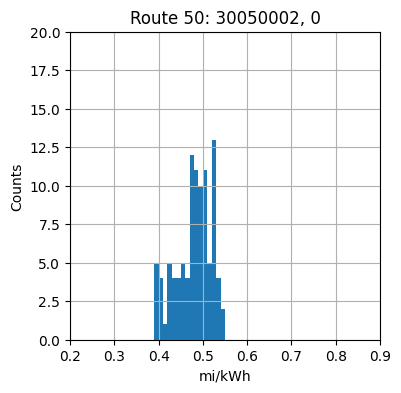

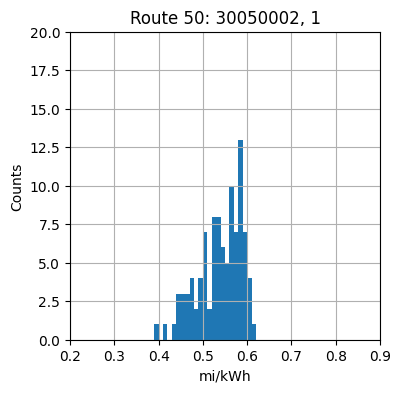

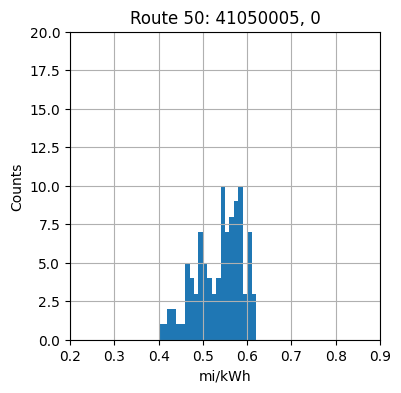

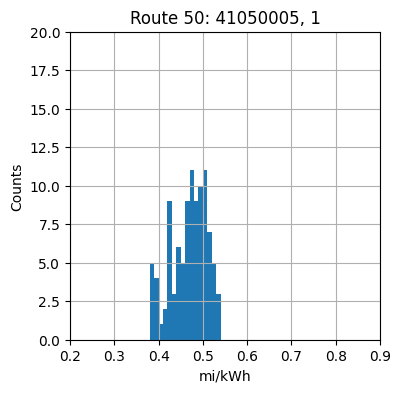

In [26]:
# Instance, Run No.
kwh_bins = np.arange(.2, .9, .01)
for index, row in selected_route_instances[:].iterrows():
    fig, ax = plt.subplots(1, 1, figsize = (4, 4), dpi=100)
    pd.Series(row.results).hist(ax=ax, bins=kwh_bins)
    #ax.hist(row.results, bins=kwh_bins, density=True)
    ax.set_ylim(0, 20)
    ax.set_xlim(.2, .9)
    ax.set_xlabel("mi/kWh")
    ax.set_ylabel("Counts")
    ax.set_title("Route {}: {}, {}".format(row.shortname, row['shape'], row.direction))
    plt.show()

In [28]:
selected_route_instances

shortname  route_id     shape direction  \
0        50    100230  30050002         0   
1        50    100230  30050002         1   
2        50    100230  41050005         0   
3        50    100230  41050005         1   

                                                path  \
0  ./KC_Example_Data/Saved_Routes/rt50_sh30050002...   
1  ./KC_Example_Data/Saved_Routes/rt50_sh30050002...   
2  ./KC_Example_Data/Saved_Routes/rt50_sh41050005...   
3  ./KC_Example_Data/Saved_Routes/rt50_sh41050005...   

                                          rider_dict  \
0  [{'AM': 40.36672799422798}, {'MID': 30.2451465...   
1  [{'AM': 35.48968253968257}, {'MID': 30.7371794...   
2  [{'AM': 40.36672799422798}, {'MID': 30.2451465...   
3  [{'AM': 35.48968253968257}, {'MID': 30.7371794...   

                                                bus  \
0  ./KC_Example_Data/Saved_Objects/Busses/XDE35.txt   
1  ./KC_Example_Data/Saved_Objects/Busses/XDE35.txt   
2  ./KC_Example_Data/Saved_Objects/Busses/XDE35.txt   
3  ./KC_Example_Data/Saved_Objects/Busses/XDE35.txt   

                         ridership_min_max  \
0   (7.137142857142857, 41.87666666666667)   
1  (7.149999999999999, 40.740151515151496)   
2   (7.137142857142857, 41.87666666666667)   
3  (7.149999999999999, 40.740151515151496)   

                                             results  
0  [0.46700287966786713, 0.4862063253288695, 0.52...  
1  [0.5647651767355443, 0.5998158580574909, 0.564...  
2  [0.5819160537879134, 0.6066032797605448, 0.585...  
3  [0.45962635086961334, 0.4887996366215553, 0.51...

0.34664090016294935 0.031989160732308605


(0.2, 0.5)

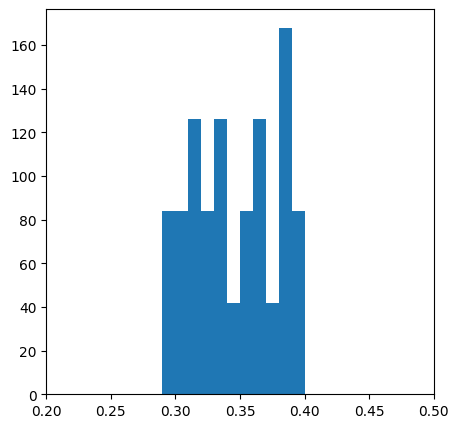

In [49]:
sorted_data = []
for entry in data_list:
    sorted_data.extend(entry)
prepped_routes['result'] = pd.Series(sorted_data)
prepped_routes = prepped_routes.dropna()
prepped_routes['result'] = prepped_routes.apply(lambda x: x.result[0], axis=1)
prepped_routes
to_save_routes = prepped_routes.filter(['shortname', 'route_id', 'shape', 'direction', 'period', 'riders', 'seeds', 'traffic', 'signal_chance', 'wind_speeds', 'wind_directions', 'result'])

prepped_routes.to_csv('sh{}_d{}.csv'.format(50, 1))
reloaded_routes = pd.read_csv('sh{}_d{}.csv'.format(50, 1))

group = reloaded_routes.groupby(['shortname', 'route_id', 'direction', 'period', 'wind_directions']).get_group((50, 100230, 1, 'PM', 'NW'))
mean = group.result.mean()
sd = group.result.std()
print(mean, sd)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
bins = list(np.arange(0, 1, .01))
ax.hist(group.result, bins=bins, density=False)
ax.set_xlim(.2, .5)

0.33836201396813564 0.03249672859083044


(0.2, 0.5)

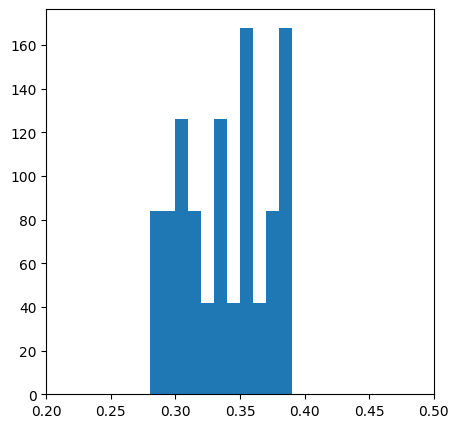

In [56]:
group = reloaded_routes.groupby(['shortname', 'route_id', 'direction', 'period', 'wind_directions']).get_group((50, 100230, 1, 'PM', 'SE')).reset_index(drop=True)
mean = group.result.mean()
sd = group.result.std()
print(mean, sd)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.hist(group.result, bins=bins, density=False)
ax.set_xlim(.2, .5)

In [27]:
idx = 1

for i in range(len(group)):
    print('{}%'.format(round(i/len(group)*100, 3)), end='\r')
    trip = op.load_trip_params(trip_path)
    
    trip.m_riders = group.iloc[i]['riders']
    trip.seed = group.iloc[i]['seeds']
    trip.traffic = group.iloc[i]['traffic']
    trip.chance_sig = group.iloc[i]['signal_chance']
    trip.wind_bearing = group.iloc[i]['wind_directions']
    trip.v_wind = group.iloc[i]['wind_speeds']
    group.at[i,'trip'] = trip

args = (group['path'][idx],group['trip'][idx],op.load_bus_params(bus_path),op.load_ESS_params(ESS_path), True, [group['seeds'][idx]])
df = kcrt.run_trip(*args)[0]

NameError: name 'group' is not defined

/tmp/ipykernel_5639/1146000478.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rundata = str(id_filter.iloc[0][1])


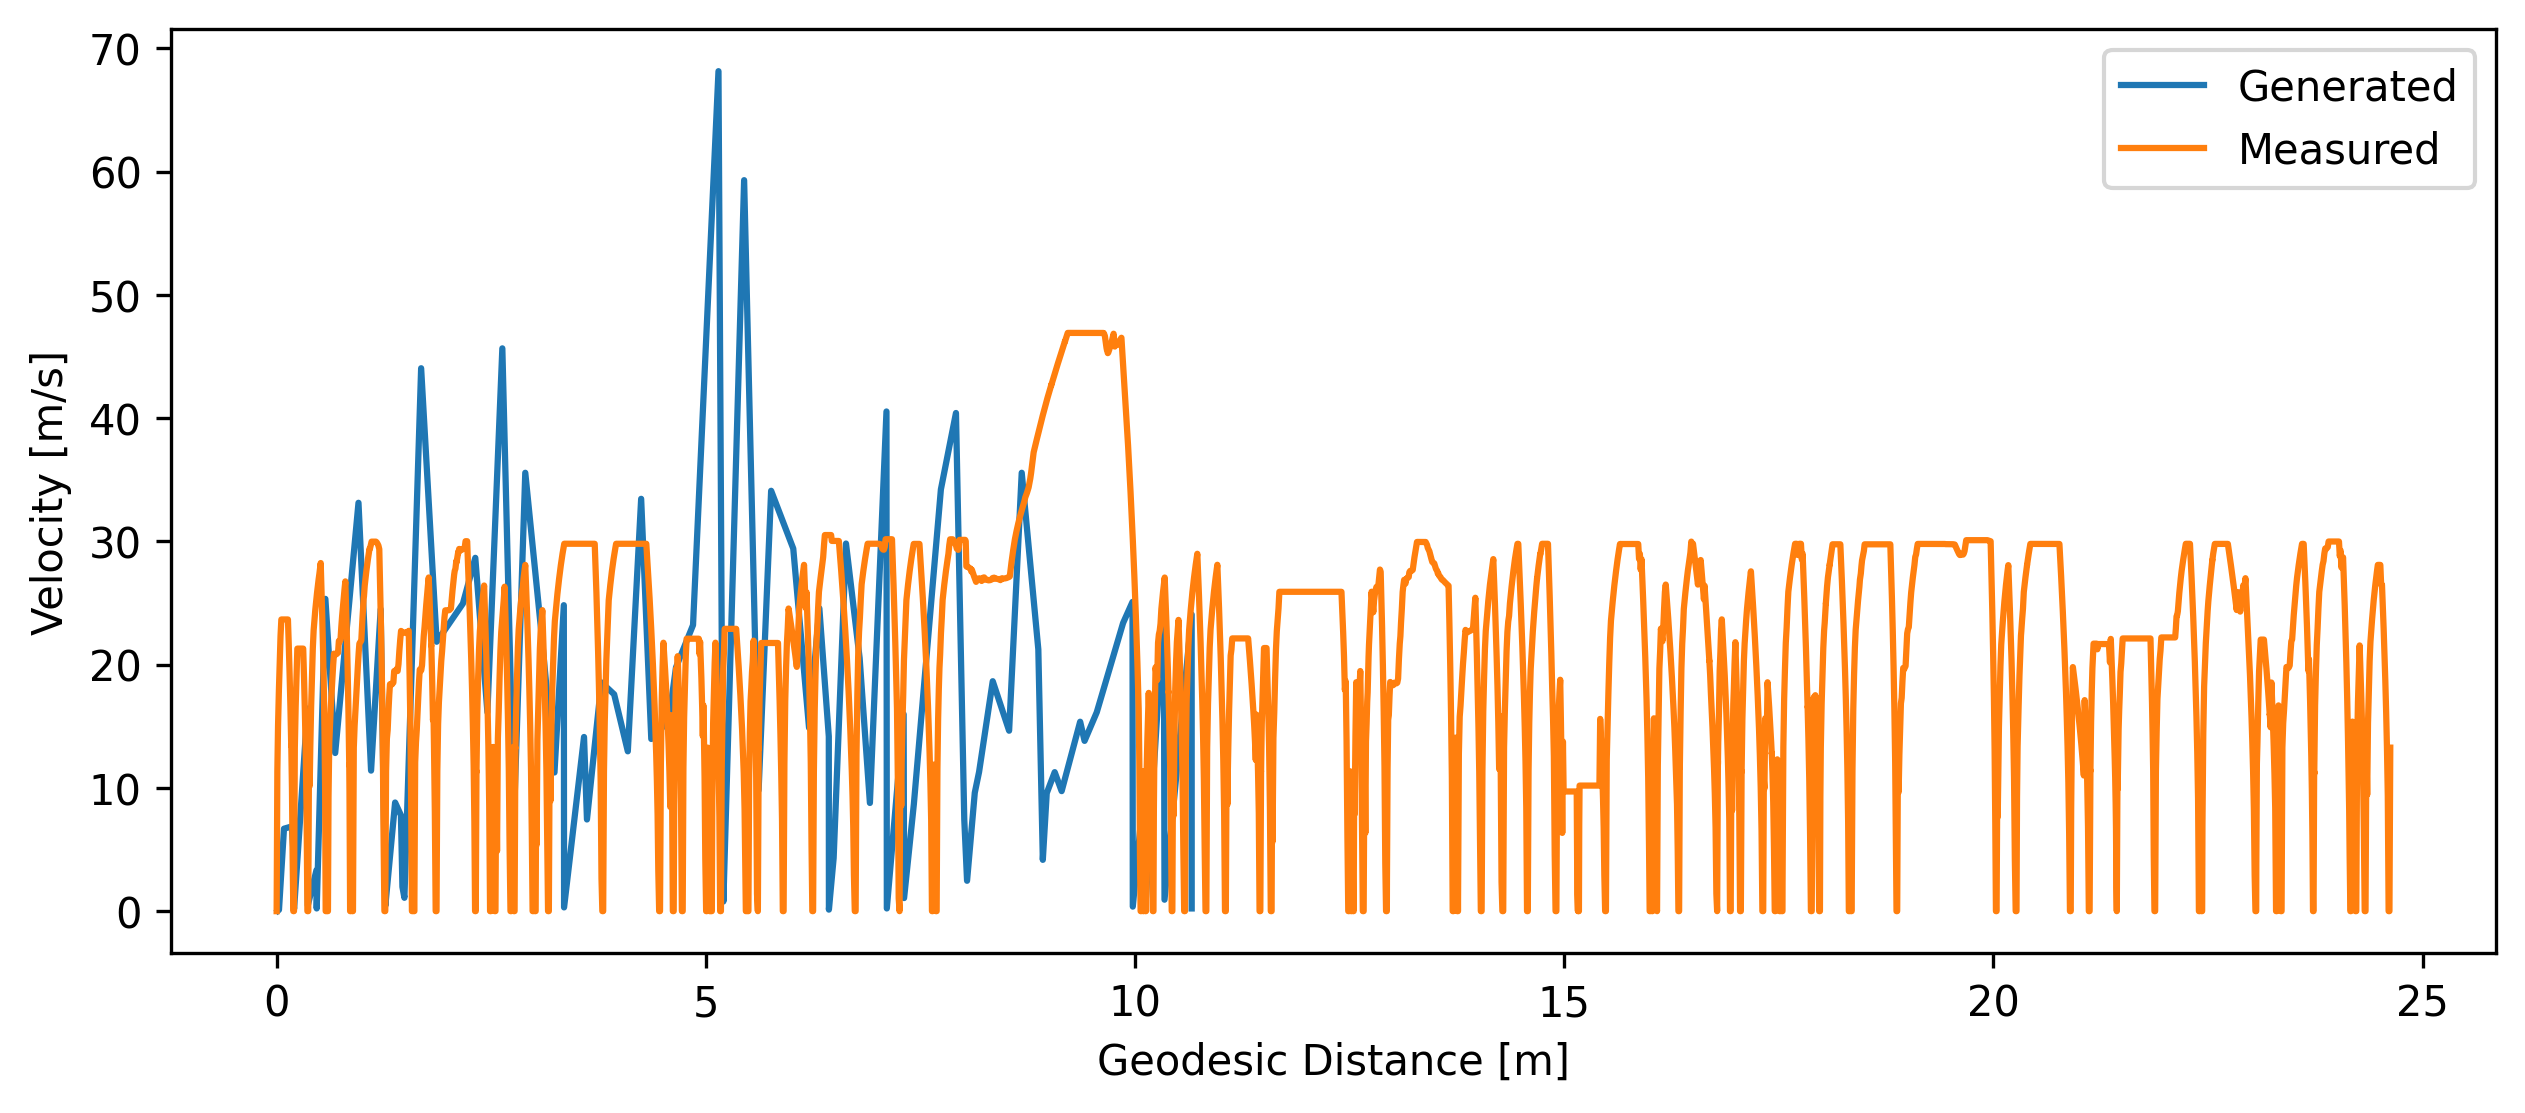

In [63]:
import shapely
import Geography_Tools as gt
import pandas as pd
import matplotlib.pyplot as plt

timelog = pd.read_csv("timelog_3.csv")
bus_filter = timelog[timelog['bus'].isin(['XDE35'])]
id_filter = bus_filter[bus_filter['rt'] == 100230]
rundata = str(id_filter.iloc[0][1])
unsorted = rundata[1:-2].split(", ")
batch_size = 9
form = '%H, %M, %S, %f'
rows = [unsorted[i:i + batch_size] for i in range(0, len(unsorted), batch_size)]
times = pd.Series(rows).apply(lambda x: datetime.datetime.strptime(", ".join(x[0:7])[32:-1], form))
geometry = pd.Series(rows).apply(lambda x: shapely.Point(", ".join(x[7:9])[1:-2].split(", ")))
dx = gt.query_distance_traveled(geometry)
dt = times.diff()
dt = dt[1:]
dt = dt.apply(lambda x: x.to_pytimedelta().total_seconds())

timedata = pd.DataFrame([dx[1:], dt, dx[1:]]).T
data = []
entry = {0:0,1:0,2:0}
for i in range(len(timedata)):
    row = timedata.iloc[i]
    if row[0] == 0:
        entry[1]+=row[1]
        entry[2]+=row[2]
    else:
        entry[1]+=row[1]
        entry[2]+=row[2]
        entry[0]+=row[0]
        
        data.append(entry)
        entry = {0:0,1:0,2:0}
data = pd.DataFrame(data)
data[2] = data[0]*1000*2.236936/data[1]
dist = dx.cumsum()
fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
#-data[1].cumsum()[2]
ax.plot(list(((data[0].cumsum())))[1:], list(data[2])[1:])
ax.plot(df['gdx'].cumsum()/1000, df['v_f']*2.236936)
ax.set_xlabel("Geodesic Distance [m]")
ax.set_ylabel("Velocity [m/s]")
ax.legend(['Generated','Measured'])

In [154]:
dt

1       1.638355
2       1.624115
3       1.546646
4       1.507319
5       1.664902
          ...   
1639    1.547192
1640    1.545456
1641    1.476771
1642    1.557509
1643    1.518952
Length: 1643, dtype: float64

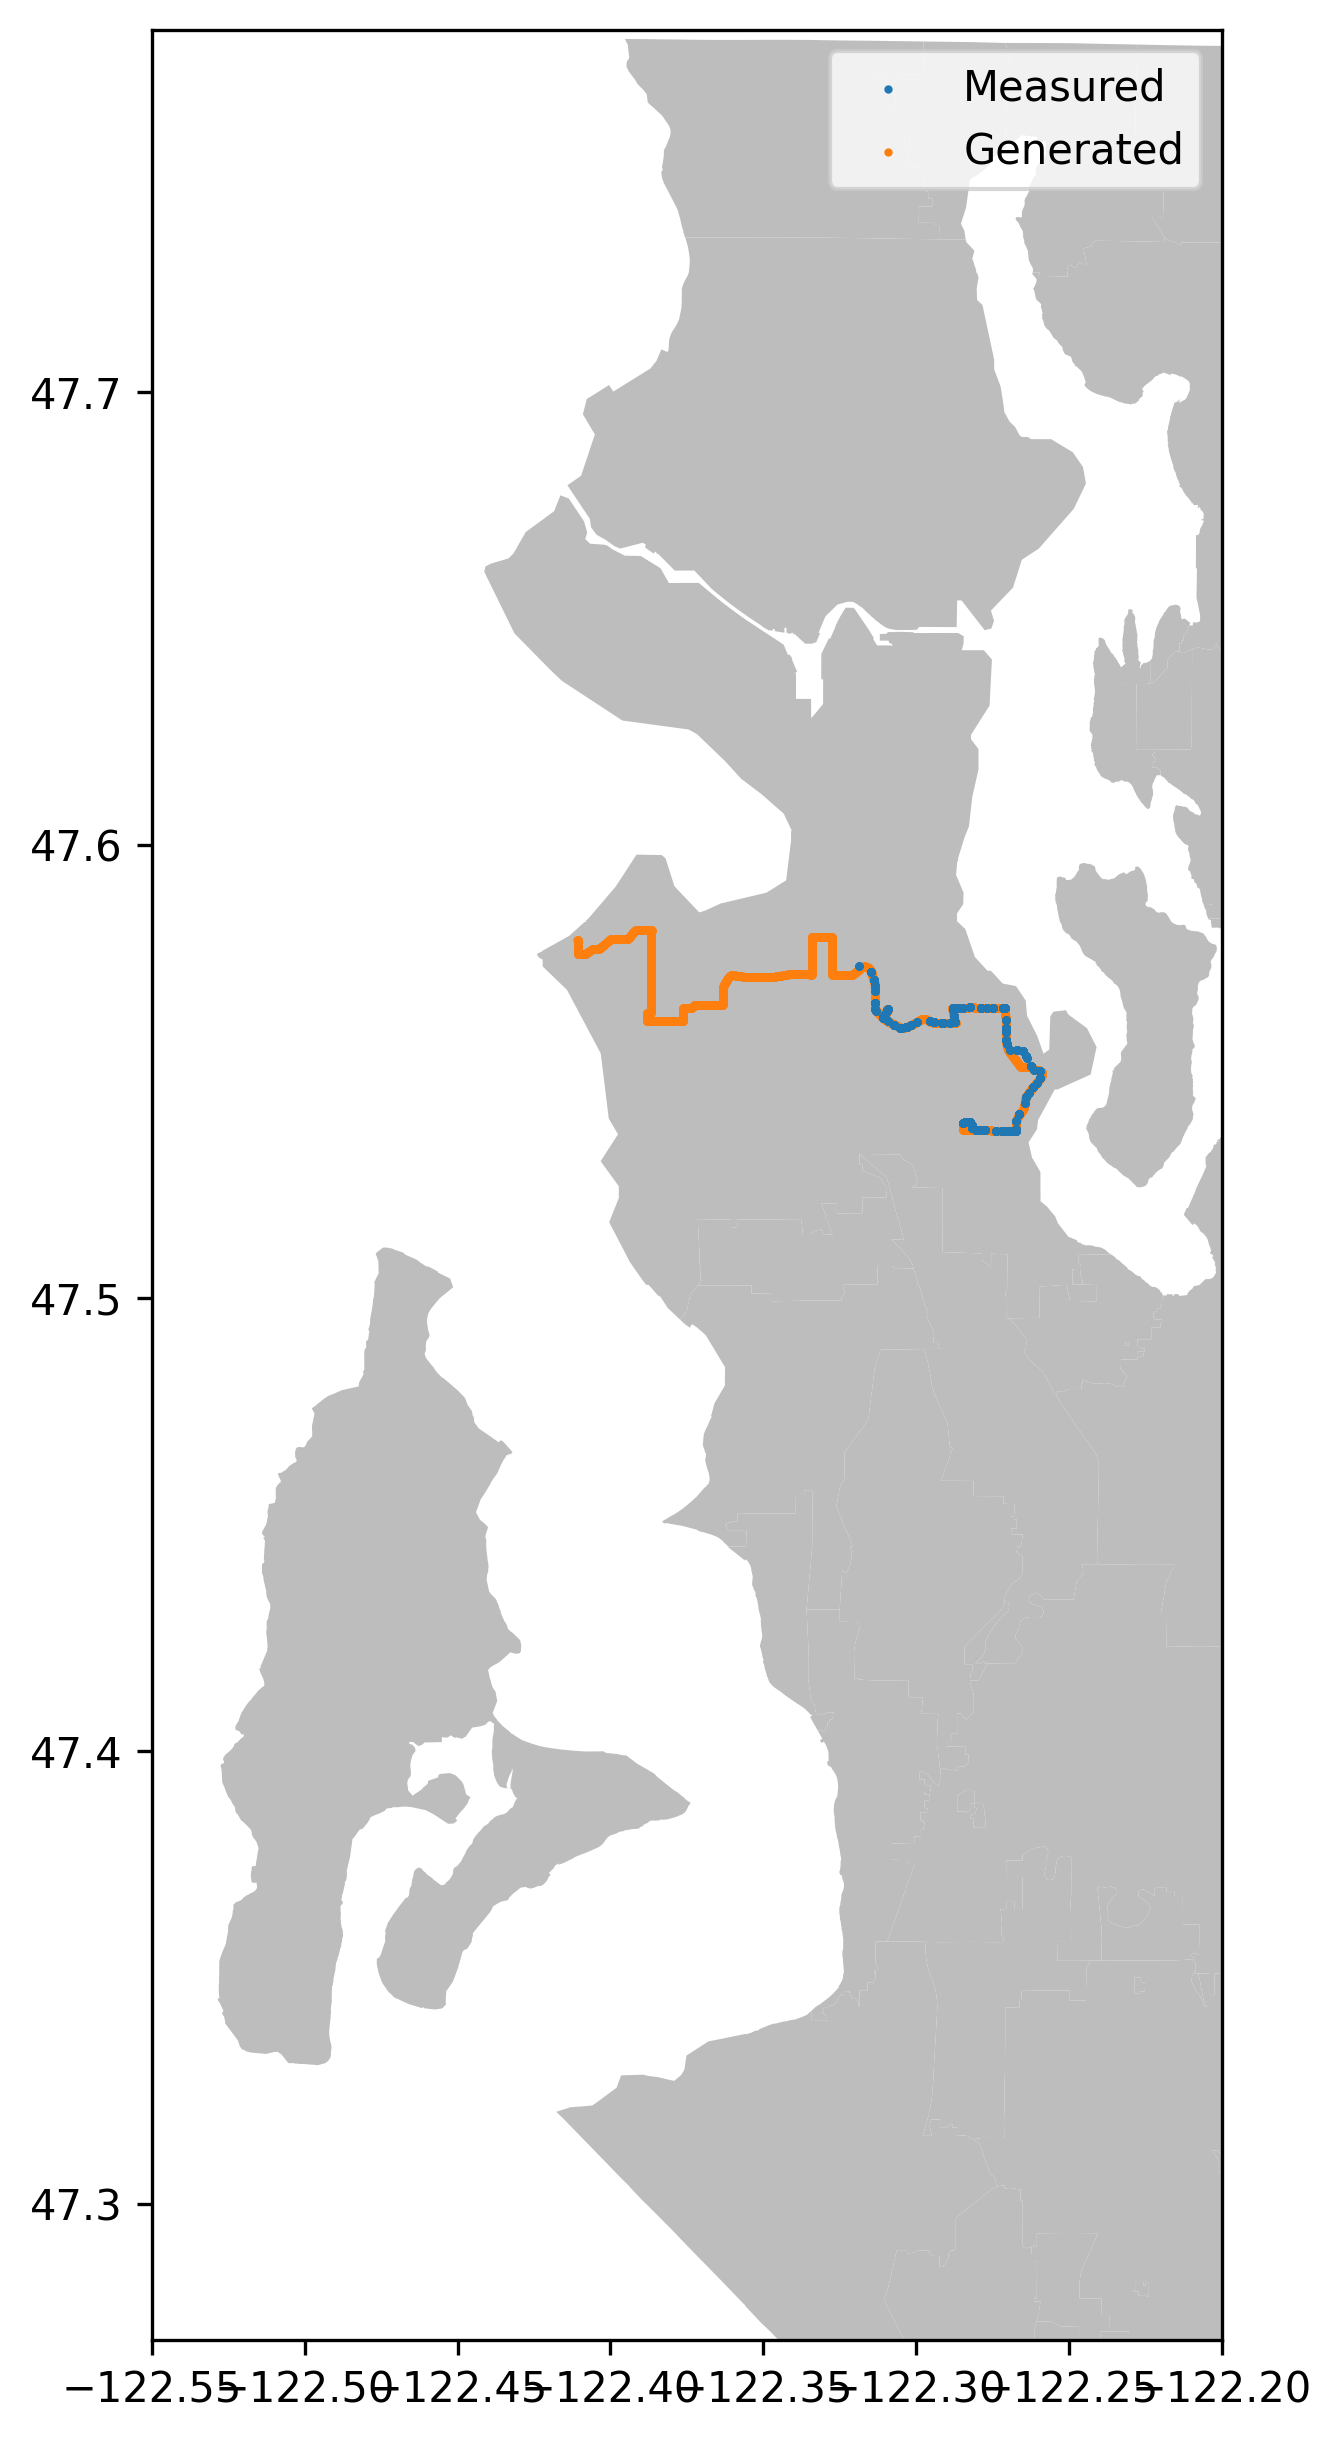

In [67]:
fig, ax = blank_kc_canvas()
gpd.GeoSeries(geometry.apply(lambda x: shapely.ops.transform(kqt._flip, x))).set_crs(epsg=4326).plot(ax=ax, zorder=5, markersize=1)
gpd.GeoSeries(gt.load_from_json(group['path'][idx]).geometry[:]).apply(lambda x: shapely.ops.transform(kqt._flip, x)).set_crs(epsg=4326).plot(ax=ax, markersize=1)
ax.set_xlim(-122.55, -122.2)
ax.set_ylim(47.27, 47.78)
ax.legend(['Measured','Generated'])

In [231]:
import KC_Route_Testing as kcrt
import importlib
import Physics_Engine as pe
import Trip_Simulator as ts
importlib.reload(pe)
importlib.reload(kcrt)
importlib.reload(ts)
importlib.reload(op)


val = xde35_routes.iloc[1:2].apply(lambda x: kcrt.run_trip(route_savepath + "rt1_sh11001003_d0.json", x.trip, x.bus, x.ESS, export_figures=True, seed_list=[1]), axis=1)

AttributeError: 'Series' object has no attribute 'trip'